# Import modules

In [24]:
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
from ultralytics import YOLO
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pickle

# Preprocess dataset to YOLO format

In [2]:
files = [x.split('\\')[-1].split('/')[-1].split('.')[0] for x in glob('yolo_train_dataset/images/*.JPG')]

In [3]:
files[:10]

['G0015158',
 'G0015159',
 'G0015160',
 'G0015161',
 'G0015162',
 'G0015163',
 'G0015164',
 'G0015165',
 'G0015166',
 'G0015167']

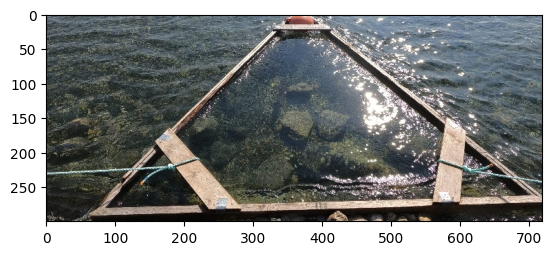

In [4]:
plt.imshow(cv2.cvtColor(cv2.imread('yolo_train_dataset/images/G0016157.JPG'), cv2.COLOR_BGR2RGB))

In [5]:
train_files, val_files = train_test_split(files, test_size=0.15, random_state=1111)

In [6]:
if os.path.exists('yolo_data'):
    shutil.rmtree('yolo_data')
os.makedirs('yolo_data/', exist_ok=True)
os.makedirs('yolo_data/train', exist_ok=True)
os.makedirs('yolo_data/val', exist_ok=True)

In [7]:
for image_id in tqdm(train_files):

    Image.open(f'yolo_train_dataset/images/{image_id}.JPG').save(f'yolo_data/train/{image_id}.jpg')
    shutil.copyfile(f'yolo_train_dataset/labels/{image_id}.txt', f'yolo_data/train/{image_id}.txt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14647/14647 [00:43<00:00, 337.23it/s]


In [8]:
for image_id in tqdm(val_files):

    Image.open(f'yolo_train_dataset/images/{image_id}.JPG').save(f'yolo_data/val/{image_id}.jpg')
    shutil.copyfile(f'yolo_train_dataset/labels/{image_id}.txt', f'yolo_data/val/{image_id}.txt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2585/2585 [00:21<00:00, 122.62it/s]


In [9]:
data_yaml = """
names: [fish, spawning_fish]
nc: 2
train: C://Users/druzh/work_flow_python/yolo_data/train
val: C://Users/druzh/work_flow_python/yolo_data/val
"""

with open('yolo_data/data.yaml', 'w') as f:
    f.write(data_yaml)

# Check GPU

In [25]:
import torch

def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

check_cuda()

11.8
CUDA Enabled: True


In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Tue Mar  5 07:11:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              22W /  85W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Train model

In [26]:
import torch

if torch.cuda.is_available():
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

GPU available


In [6]:
torch.__version__

'2.0.0+cu118'

In [15]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(data="yolo_data/data.yaml", epochs=100, device='cuda:0')

New https://pypi.org/project/ultralytics/8.1.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.20 🚀 Python-3.8.10 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

train: Scanning C:\Users\druzh\work_flow_python\yolo_data\train... 14647 images, 5336 backgrounds, 0 corrupt: 100%|██████████| 14647/14647 [00:10<00:00, 1389.93it/s]


train: New cache created: C:\Users\druzh\work_flow_python\yolo_data\train.cache


val: Scanning C:\Users\druzh\work_flow_python\yolo_data\val... 2585 images, 952 backgrounds, 0 corrupt: 100%|██████████| 2585/2585 [00:02<00:00, 999.09it/s] 


val: New cache created: C:\Users\druzh\work_flow_python\yolo_data\val.cache
Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train20
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G      2.493      3.069      1.631         20        640: 100%|██████████| 916/916 [01:55<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.49it/s]


                   all       2585       3763       0.51      0.561      0.524      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.43G      2.273      1.964      1.488         13        640: 100%|██████████| 916/916 [01:51<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.09it/s]

                   all       2585       3763      0.534      0.586       0.51      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.41G      2.276      1.778      1.506         11        640: 100%|██████████| 916/916 [01:53<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.27it/s]


                   all       2585       3763      0.532      0.496      0.466      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.42G      2.266      1.717      1.518         17        640: 100%|██████████| 916/916 [01:52<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.61it/s]


                   all       2585       3763      0.584      0.532      0.538      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.4G      2.228      1.638      1.499         27        640: 100%|██████████| 916/916 [01:53<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.98it/s]

                   all       2585       3763       0.63      0.577       0.58      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.41G        2.2      1.592      1.484         19        640: 100%|██████████| 916/916 [01:54<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.28it/s]


                   all       2585       3763      0.598       0.58       0.58      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G      2.178      1.567      1.478         15        640: 100%|██████████| 916/916 [01:54<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.62it/s]

                   all       2585       3763      0.634      0.602      0.622      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.4G      2.162      1.521      1.465         16        640: 100%|██████████| 916/916 [01:55<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.07it/s]


                   all       2585       3763      0.632      0.612       0.64      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.41G      2.148        1.5       1.45         25        640: 100%|██████████| 916/916 [01:55<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.90it/s]


                   all       2585       3763      0.648      0.655      0.656      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.41G      2.134      1.477      1.442          7        640: 100%|██████████| 916/916 [01:56<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.45it/s]

                   all       2585       3763      0.685      0.651       0.67      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.4G      2.122      1.461      1.435         12        640: 100%|██████████| 916/916 [01:55<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.45it/s]

                   all       2585       3763      0.675      0.658      0.676       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.4G      2.101      1.439      1.425         32        640: 100%|██████████| 916/916 [01:56<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.30it/s]

                   all       2585       3763      0.688      0.662      0.701      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.4G      2.094      1.425       1.42         19        640: 100%|██████████| 916/916 [01:55<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.06it/s]


                   all       2585       3763      0.667      0.669      0.673       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.4G      2.081      1.416      1.409         25        640: 100%|██████████| 916/916 [01:55<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.32it/s]

                   all       2585       3763      0.721      0.668      0.706      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.4G      2.076        1.4      1.405         20        640: 100%|██████████| 916/916 [01:55<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.41it/s]


                   all       2585       3763      0.724      0.674      0.721      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.4G      2.061       1.38      1.399         23        640: 100%|██████████| 916/916 [01:55<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.49it/s]

                   all       2585       3763      0.723      0.685      0.738      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.4G      2.054      1.369       1.39         27        640: 100%|██████████| 916/916 [01:55<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.11it/s]

                   all       2585       3763      0.746      0.687      0.737      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.4G      2.048      1.367      1.385         26        640: 100%|██████████| 916/916 [01:55<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.65it/s]

                   all       2585       3763      0.712      0.694      0.739      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.41G      2.029      1.349      1.381         11        640: 100%|██████████| 916/916 [01:55<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.41it/s]

                   all       2585       3763      0.717      0.702      0.728      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.4G      2.029      1.336      1.372         35        640: 100%|██████████| 916/916 [01:55<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.50it/s]

                   all       2585       3763      0.732      0.709      0.749      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.41G      2.022       1.32      1.376          8        640: 100%|██████████| 916/916 [01:56<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.23it/s]

                   all       2585       3763      0.752      0.691      0.748       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.4G       2.01      1.309      1.366         28        640: 100%|██████████| 916/916 [01:55<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.64it/s]


                   all       2585       3763      0.755      0.715      0.768      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.4G      2.008      1.311      1.368         24        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.28it/s]

                   all       2585       3763      0.739      0.729      0.771       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.4G      1.991      1.297      1.359         19        640: 100%|██████████| 916/916 [01:56<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.19it/s]

                   all       2585       3763      0.739       0.73      0.776      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.4G       1.99       1.29      1.356         33        640: 100%|██████████| 916/916 [01:56<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.11it/s]

                   all       2585       3763      0.723      0.728      0.758      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.41G       1.98      1.273      1.349         18        640: 100%|██████████| 916/916 [01:57<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.28it/s]

                   all       2585       3763      0.747      0.722      0.768      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.4G      1.978      1.258      1.345         24        640: 100%|██████████| 916/916 [01:57<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.11it/s]


                   all       2585       3763      0.737      0.761      0.793      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.4G      1.965      1.252      1.338         16        640: 100%|██████████| 916/916 [01:56<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.47it/s]

                   all       2585       3763      0.763      0.745      0.798      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.4G      1.956      1.245      1.334         21        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.28it/s]

                   all       2585       3763      0.753      0.748      0.791       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.41G       1.95      1.241      1.335         12        640: 100%|██████████| 916/916 [01:58<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.40it/s]

                   all       2585       3763      0.763      0.748      0.801      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.41G      1.937      1.216      1.326         10        640: 100%|██████████| 916/916 [01:57<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.21it/s]


                   all       2585       3763      0.745      0.764      0.801      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.4G      1.929      1.205       1.32         25        640: 100%|██████████| 916/916 [01:59<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.27it/s]


                   all       2585       3763       0.76      0.756      0.797      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.4G      1.929      1.212      1.319         21        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.89it/s]

                   all       2585       3763      0.763       0.76      0.808      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.4G       1.92      1.205      1.317         20        640: 100%|██████████| 916/916 [01:56<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.55it/s]

                   all       2585       3763      0.767      0.763      0.813      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.4G      1.911      1.183      1.309         19        640: 100%|██████████| 916/916 [01:57<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.51it/s]

                   all       2585       3763      0.776      0.765      0.817      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.4G      1.903      1.183      1.306         25        640: 100%|██████████| 916/916 [01:56<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.25it/s]

                   all       2585       3763      0.785      0.777      0.813      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.4G      1.901      1.169      1.305         21        640: 100%|██████████| 916/916 [01:56<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.30it/s]

                   all       2585       3763      0.764      0.784      0.815      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.4G      1.891      1.163      1.303         12        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.25it/s]

                   all       2585       3763      0.774      0.775      0.815      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.4G      1.877      1.153      1.293         22        640: 100%|██████████| 916/916 [01:57<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.14it/s]

                   all       2585       3763      0.773      0.793      0.824      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.4G       1.88      1.152      1.292         17        640: 100%|██████████| 916/916 [01:57<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.34it/s]

                   all       2585       3763      0.783      0.782      0.827      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.4G      1.871       1.14       1.29         24        640: 100%|██████████| 916/916 [01:57<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.25it/s]

                   all       2585       3763      0.782      0.781      0.828      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.4G      1.863      1.136      1.286         18        640: 100%|██████████| 916/916 [01:57<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.37it/s]

                   all       2585       3763      0.785      0.781      0.827      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.4G      1.847      1.122      1.282         10        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.72it/s]

                   all       2585       3763      0.802      0.778      0.837        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.4G      1.846      1.113      1.275         40        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.59it/s]

                   all       2585       3763      0.817      0.782      0.844      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.4G      1.843      1.113      1.275         21        640: 100%|██████████| 916/916 [01:58<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.53it/s]

                   all       2585       3763      0.791      0.787      0.842      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.4G       1.83      1.101      1.272         32        640: 100%|██████████| 916/916 [01:57<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.42it/s]

                   all       2585       3763      0.788      0.801      0.845      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.4G      1.832      1.097      1.275         20        640: 100%|██████████| 916/916 [01:57<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.75it/s]

                   all       2585       3763      0.798      0.796      0.847      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.4G      1.818      1.085      1.264         17        640: 100%|██████████| 916/916 [01:58<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.61it/s]

                   all       2585       3763      0.802      0.807      0.851      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.4G      1.816      1.086      1.265         30        640: 100%|██████████| 916/916 [01:57<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.48it/s]

                   all       2585       3763      0.799      0.807      0.855      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.41G      1.805      1.074       1.26         16        640: 100%|██████████| 916/916 [01:57<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.41it/s]

                   all       2585       3763      0.802      0.812      0.856       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.4G      1.785       1.06      1.247         29        640: 100%|██████████| 916/916 [01:57<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.50it/s]

                   all       2585       3763       0.81       0.81      0.858      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.4G      1.777      1.051      1.246         28        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.46it/s]

                   all       2585       3763       0.82       0.81       0.86      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.4G      1.785      1.054      1.248         17        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.42it/s]

                   all       2585       3763      0.819      0.812      0.863      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.41G      1.777      1.037      1.238         12        640: 100%|██████████| 916/916 [01:58<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.50it/s]

                   all       2585       3763      0.815      0.817      0.864      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.41G      1.755      1.027      1.232         13        640: 100%|██████████| 916/916 [01:57<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.30it/s]

                   all       2585       3763       0.82      0.817      0.864       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.4G      1.745      1.021      1.233          6        640: 100%|██████████| 916/916 [01:57<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.59it/s]

                   all       2585       3763      0.823      0.815      0.868      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.41G       1.75      1.018      1.234          8        640: 100%|██████████| 916/916 [01:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.34it/s]

                   all       2585       3763      0.809       0.83      0.869      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.4G      1.742      1.013      1.228         20        640: 100%|██████████| 916/916 [01:58<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.34it/s]

                   all       2585       3763      0.819       0.83      0.873      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.4G      1.725      1.002      1.224         16        640: 100%|██████████| 916/916 [01:58<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.45it/s]

                   all       2585       3763      0.821       0.83      0.873      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.4G      1.726     0.9972      1.219         19        640: 100%|██████████| 916/916 [01:58<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.55it/s]

                   all       2585       3763      0.825      0.832      0.876       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.4G      1.708     0.9909      1.214          9        640: 100%|██████████| 916/916 [01:59<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.42it/s]

                   all       2585       3763      0.818      0.833      0.876      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.4G      1.708     0.9821      1.211         27        640: 100%|██████████| 916/916 [01:58<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.33it/s]

                   all       2585       3763      0.828      0.828      0.878      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.4G      1.692     0.9771      1.211         26        640: 100%|██████████| 916/916 [01:58<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.62it/s]

                   all       2585       3763      0.825      0.835       0.88      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.4G      1.685     0.9693      1.202         23        640: 100%|██████████| 916/916 [02:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.17it/s]

                   all       2585       3763      0.827      0.836      0.881      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.4G      1.688     0.9666      1.202         24        640: 100%|██████████| 916/916 [02:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.24it/s]

                   all       2585       3763      0.828      0.841      0.882      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.4G      1.668     0.9549        1.2         23        640: 100%|██████████| 916/916 [02:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.09it/s]

                   all       2585       3763      0.832       0.84      0.884      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.4G      1.662     0.9447      1.192         12        640: 100%|██████████| 916/916 [02:00<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.05it/s]

                   all       2585       3763       0.83      0.839      0.884      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.4G       1.67     0.9456      1.194         28        640: 100%|██████████| 916/916 [02:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.30it/s]

                   all       2585       3763      0.835      0.836      0.886      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.4G      1.646      0.938      1.187         14        640: 100%|██████████| 916/916 [02:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.22it/s]

                   all       2585       3763      0.843      0.828      0.889      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.4G      1.642     0.9306      1.186         23        640: 100%|██████████| 916/916 [01:59<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.34it/s]


                   all       2585       3763      0.847      0.829       0.89      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.4G      1.632     0.9202       1.18         20        640: 100%|██████████| 916/916 [02:01<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.22it/s]

                   all       2585       3763      0.848      0.826       0.89      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.4G      1.619     0.9143      1.178         26        640: 100%|██████████| 916/916 [02:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.25it/s]

                   all       2585       3763       0.85      0.828      0.892      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.4G      1.622     0.9143      1.175         22        640: 100%|██████████| 916/916 [01:59<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.14it/s]

                   all       2585       3763      0.853      0.824      0.892      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.4G      1.608     0.9021      1.166         15        640: 100%|██████████| 916/916 [02:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.14it/s]

                   all       2585       3763      0.854      0.826      0.891      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.4G      1.602      0.897      1.163         26        640: 100%|██████████| 916/916 [02:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.29it/s]

                   all       2585       3763      0.845      0.832      0.891      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.4G      1.588     0.8911      1.159         16        640: 100%|██████████| 916/916 [01:59<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.24it/s]

                   all       2585       3763      0.845      0.834      0.892      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.4G      1.581     0.8863      1.156         11        640: 100%|██████████| 916/916 [01:59<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.30it/s]

                   all       2585       3763      0.848      0.835      0.893      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.4G      1.576     0.8794      1.153         29        640: 100%|██████████| 916/916 [02:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.33it/s]

                   all       2585       3763      0.852      0.833      0.894      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.4G      1.566     0.8717       1.15         14        640: 100%|██████████| 916/916 [01:59<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.09it/s]

                   all       2585       3763      0.856      0.832      0.895      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.4G       1.56     0.8686      1.151         18        640: 100%|██████████| 916/916 [02:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.98it/s]

                   all       2585       3763      0.854      0.833      0.896      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.4G      1.546     0.8609      1.141         18        640: 100%|██████████| 916/916 [02:05<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.99it/s]


                   all       2585       3763      0.857      0.835      0.897      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.4G      1.543     0.8574       1.14         25        640: 100%|██████████| 916/916 [02:04<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.79it/s]

                   all       2585       3763      0.859      0.834      0.898      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.4G      1.534     0.8525      1.137         24        640: 100%|██████████| 916/916 [02:04<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.15it/s]

                   all       2585       3763       0.86      0.836      0.898      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.4G      1.526     0.8422      1.134         23        640: 100%|██████████| 916/916 [02:02<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.93it/s]

                   all       2585       3763      0.859      0.837      0.899       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.4G      1.519     0.8418      1.129         30        640: 100%|██████████| 916/916 [02:02<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00, 10.09it/s]

                   all       2585       3763      0.859      0.837      0.899      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.4G      1.505     0.8249      1.123         25        640: 100%|██████████| 916/916 [02:01<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.56it/s]

                   all       2585       3763      0.856      0.843        0.9      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.41G      1.501     0.8303       1.12         10        640: 100%|██████████| 916/916 [01:59<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.48it/s]

                   all       2585       3763      0.858      0.845      0.902      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.41G      1.493     0.8242      1.118         14        640: 100%|██████████| 916/916 [01:59<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.16it/s]

                   all       2585       3763      0.858      0.843      0.901      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.4G      1.482     0.8212      1.114         18        640: 100%|██████████| 916/916 [01:59<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.37it/s]

                   all       2585       3763      0.859      0.844      0.902      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.4G      1.482     0.8111      1.113         16        640: 100%|██████████| 916/916 [01:58<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.27it/s]

                   all       2585       3763      0.857      0.849      0.904      0.487


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.4G      1.414     0.7504      1.122          2        640: 100%|██████████| 916/916 [01:52<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.34it/s]

                   all       2585       3763      0.859      0.848      0.904      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.41G      1.361     0.7178      1.105          6        640: 100%|██████████| 916/916 [01:55<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.67it/s]

                   all       2585       3763      0.859       0.85      0.905      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.4G      1.354     0.7172        1.1          9        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.37it/s]

                   all       2585       3763      0.861       0.85      0.905      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.4G      1.332     0.7002      1.091         10        640: 100%|██████████| 916/916 [01:55<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.74it/s]

                   all       2585       3763      0.862       0.85      0.906      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.4G      1.324     0.6985      1.086         12        640: 100%|██████████| 916/916 [01:56<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.32it/s]

                   all       2585       3763      0.862       0.85      0.907      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.41G      1.312     0.6896      1.079          9        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.91it/s]

                   all       2585       3763       0.86      0.853      0.907      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.4G      1.301     0.6848      1.077          3        640: 100%|██████████| 916/916 [01:56<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.65it/s]

                   all       2585       3763      0.863      0.852      0.908      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.4G      1.291     0.6796      1.074          7        640: 100%|██████████| 916/916 [01:53<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.87it/s]

                   all       2585       3763      0.865      0.854      0.908      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.4G      1.277     0.6718      1.066          3        640: 100%|██████████| 916/916 [01:52<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 10.83it/s]

                   all       2585       3763      0.854      0.863      0.909      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.41G      1.268     0.6645      1.063         11        640: 100%|██████████| 916/916 [01:51<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:07<00:00, 11.23it/s]

                   all       2585       3763      0.857      0.862      0.909      0.498



100 epochs completed in 3.505 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 6.2MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics YOLOv8.1.20 🚀 Python-3.8.10 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:08<00:00,  9.90it/s]


                   all       2585       3763      0.857      0.862      0.909      0.498
                  fish       2585       3226      0.826      0.828      0.879      0.456
         spawning_fish       2585        537      0.889      0.896      0.939       0.54
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train20


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002881CC17F10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

# Create submission file

[ { 

“filename”: “…”,          - имя файла

“id”: “…”,                     - ID распознаннового объекта

“bbox”: […],                - bbox в формате xywh распознанного объекта

“conf”: …                    - уверенность предсказания распознанного объекта

},

{…},

….

{…},

}]

In [27]:
from ultralytics import YOLO

In [28]:
model = YOLO('runs/detect/train20/weights/best.pt')

In [11]:
def resize(image_path):
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (720, 480))
    img1 = resized_img[180:, ::]
    return img1, resized_img

In [20]:
img = resize(r"data_for_sub/103GOPRO/G0018163.jpg")
tmp = model.predict(img, verbose=True)[0]
print(tmp.boxes.cls)
data_bbox = []
for bbox in tmp.boxes.xyxy.cpu().detach().numpy():
    data_bbox.append([bbox[0] / 720, (bbox[1] + 180) / 480, bbox[2] / 720, (bbox[3] + 180) / 480])
    print([bbox[0] / 720, (bbox[1] + 180) / 480, bbox[2] / 720, (bbox[3] + 180) / 480])


0: 640x640 7 fishs, 1 spawning_fish, 1: 640x640 7 fishs, 91.3ms
Speed: 0.0ms preprocess, 45.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
[0.4619376288519965, 0.7188271522521973, 0.5232811821831598, 0.8496571540832519]
[0.4500604417588976, 0.5310644467671712, 0.5409051683213976, 0.5950300534566243]
[0.5188912285698785, 0.5246884981791179, 0.6060154808892144, 0.5879757563273112]
[0.37803170945909287, 0.6673042933146159, 0.43572349548339845, 0.7981196721394856]
[0.4861792670355903, 0.5795409679412842, 0.5896617041693794, 0.6507586797078451]
[0.534671401977539, 0.6153953075408936, 0.5816650390625, 0.7155934651692708]
[0.4568364037407769, 0.837667179107666, 0.5129410637749566, 0.9387030283610026]
[0.10791363186306424, 0.6130917549133301, 0.18287453121609157, 0.6785651206970215]


In [21]:
img = cv2.imread("data_for_sub/103GOPRO/G0018163.jpg")
print(img.shape)
for data in data_bbox:
    print()
    cv2.rectangle(img, ( int(data[0] * 5184),      int(data[1] * 3888)), (int(data[2] * 5184),      int(data[3] * 3888)), (0, 255, 0), 10)

img = cv2.resize(img, (720, 480))

cv2.imshow("gg", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

(3888, 5184, 3)










In [12]:
model = YOLO('runs/detect/train20/weights/best.pt')

In [22]:
results = []
for test_file in tqdm(glob(r'data_for_sub/103GOPRO/*.JPG')):

    image_id = test_file.split('\\')[-1].split('/')[-1].split('.')[0]

    img = resize(test_file)
    
    result = model.predict(img, verbose=True)[0]
    if len(result.boxes.conf) == 0:
        result = {
            "filename": test_file,
            "id": [],
            "bbox": [],
            "conf": [],
            "classes": []
        }
    else:
        bbox_data = []
        for bbox in result.boxes.xyxy.cpu().detach().numpy():
            bbox_data.append([bbox[0] / 720, (bbox[1] + 180) / 480, bbox[2] / 720, (bbox[3] + 180) / 480])
        result = {
            "filename": test_file,
            "id": [i for i in range(len(result.boxes.conf))],
            "bbox": bbox_data,
            "conf": result.boxes.conf.cpu().detach().numpy(),
            "classes": result.boxes.cls
        }

    results.append(result)
result

  0%|                                                                                                                                                                                                          | 0/998 [00:00<?, ?it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 83.6ms
Speed: 4.7ms preprocess, 41.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  0%|▏                                                                                                                                                                                                 | 1/998 [00:00<04:23,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 81.4ms
Speed: 4.0ms preprocess, 40.7ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|▍                                                                                                                                                                                                 | 2/998 [00:00<04:29,  3.70it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 80.9ms
Speed: 4.2ms preprocess, 40.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  0%|▌                                                                                                                                                                                                 | 3/998 [00:00<04:23,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 79.0ms
Speed: 6.1ms preprocess, 39.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  0%|▊                                                                                                                                                                                                 | 4/998 [00:01<04:23,  3.77it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 80.2ms
Speed: 3.8ms preprocess, 40.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  1%|▉                                                                                                                                                                                                 | 5/998 [00:01<04:23,  3.77it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 71.8ms
Speed: 4.3ms preprocess, 35.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▏                                                                                                                                                                                                | 6/998 [00:01<04:23,  3.77it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 73.0ms
Speed: 6.5ms preprocess, 36.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▎                                                                                                                                                                                                | 7/998 [00:01<04:23,  3.76it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 78.1ms
Speed: 4.4ms preprocess, 39.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▌                                                                                                                                                                                                | 8/998 [00:02<04:21,  3.78it/s]


0: 640x640 7 fishs, 1 spawning_fish, 1: 640x640 7 fishs, 77.6ms
Speed: 7.6ms preprocess, 38.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▋                                                                                                                                                                                                | 9/998 [00:02<04:17,  3.83it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 70.8ms
Speed: 7.2ms preprocess, 35.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|█▉                                                                                                                                                                                               | 10/998 [00:02<04:18,  3.83it/s]


0: 640x640 2 fishs, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 76.1ms
Speed: 8.0ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  1%|██▏                                                                                                                                                                                              | 11/998 [00:02<04:17,  3.84it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 72.1ms
Speed: 3.8ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|██▎                                                                                                                                                                                              | 12/998 [00:03<04:21,  3.77it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 76.7ms
Speed: 8.8ms preprocess, 38.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|██▌                                                                                                                                                                                              | 13/998 [00:03<04:21,  3.77it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 71.6ms
Speed: 4.2ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  1%|██▋                                                                                                                                                                                              | 14/998 [00:03<04:19,  3.80it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 76.1ms
Speed: 6.4ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|██▉                                                                                                                                                                                              | 15/998 [00:03<04:16,  3.83it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 72.3ms
Speed: 4.3ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|███                                                                                                                                                                                              | 16/998 [00:04<04:13,  3.88it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 76.7ms
Speed: 6.3ms preprocess, 38.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|███▎                                                                                                                                                                                             | 17/998 [00:04<04:13,  3.88it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 75.6ms
Speed: 5.9ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  2%|███▍                                                                                                                                                                                             | 18/998 [00:04<04:14,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.2ms
Speed: 9.1ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|███▋                                                                                                                                                                                             | 19/998 [00:04<04:09,  3.92it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 70.3ms
Speed: 5.0ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|███▊                                                                                                                                                                                             | 20/998 [00:05<04:10,  3.91it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 77.8ms
Speed: 3.4ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|████                                                                                                                                                                                             | 21/998 [00:05<04:08,  3.93it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 77.3ms
Speed: 6.5ms preprocess, 38.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|████▎                                                                                                                                                                                            | 22/998 [00:05<04:09,  3.91it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.0ms
Speed: 7.6ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|████▍                                                                                                                                                                                            | 23/998 [00:05<04:08,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 75.9ms
Speed: 5.4ms preprocess, 37.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|████▋                                                                                                                                                                                            | 24/998 [00:06<04:07,  3.94it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 70.6ms
Speed: 4.4ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|████▊                                                                                                                                                                                            | 25/998 [00:06<04:07,  3.94it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 70.3ms
Speed: 5.0ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████                                                                                                                                                                                            | 26/998 [00:06<04:05,  3.96it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 65.8ms
Speed: 7.0ms preprocess, 32.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████▏                                                                                                                                                                                           | 27/998 [00:06<04:05,  3.96it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 70.1ms
Speed: 4.2ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████▍                                                                                                                                                                                           | 28/998 [00:07<04:03,  3.98it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 82.0ms
Speed: 3.4ms preprocess, 41.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████▌                                                                                                                                                                                           | 29/998 [00:07<04:05,  3.94it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 85.0ms
Speed: 0.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████▊                                                                                                                                                                                           | 30/998 [00:07<04:03,  3.98it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 82.1ms
Speed: 4.3ms preprocess, 41.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█████▉                                                                                                                                                                                           | 31/998 [00:08<04:04,  3.95it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.7ms
Speed: 4.1ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|██████▏                                                                                                                                                                                          | 32/998 [00:08<04:06,  3.92it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 70.8ms
Speed: 3.8ms preprocess, 35.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|██████▍                                                                                                                                                                                          | 33/998 [00:08<04:06,  3.91it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 79.8ms
Speed: 5.0ms preprocess, 39.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  3%|██████▌                                                                                                                                                                                          | 34/998 [00:08<04:08,  3.87it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 75.2ms
Speed: 5.0ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|██████▊                                                                                                                                                                                          | 35/998 [00:09<04:08,  3.88it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.6ms
Speed: 4.5ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|██████▉                                                                                                                                                                                          | 36/998 [00:09<04:09,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 80.2ms
Speed: 5.4ms preprocess, 40.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  4%|███████▏                                                                                                                                                                                         | 37/998 [00:09<04:07,  3.88it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.3ms
Speed: 6.1ms preprocess, 37.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


  4%|███████▎                                                                                                                                                                                         | 38/998 [00:09<04:06,  3.89it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 69.5ms
Speed: 6.8ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  4%|███████▌                                                                                                                                                                                         | 39/998 [00:10<04:08,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 67.3ms
Speed: 4.7ms preprocess, 33.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


  4%|███████▋                                                                                                                                                                                         | 40/998 [00:10<04:08,  3.86it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.9ms
Speed: 6.9ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|███████▉                                                                                                                                                                                         | 41/998 [00:10<04:07,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 2 fishs, 79.7ms
Speed: 4.8ms preprocess, 39.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  4%|████████                                                                                                                                                                                         | 42/998 [00:10<04:07,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.8ms
Speed: 5.0ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  4%|████████▎                                                                                                                                                                                        | 43/998 [00:11<04:06,  3.87it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.9ms
Speed: 6.0ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|████████▌                                                                                                                                                                                        | 44/998 [00:11<04:04,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 66.4ms
Speed: 4.5ms preprocess, 33.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  5%|████████▋                                                                                                                                                                                        | 45/998 [00:11<04:05,  3.88it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 72.2ms
Speed: 6.4ms preprocess, 36.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


  5%|████████▉                                                                                                                                                                                        | 46/998 [00:11<04:04,  3.90it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 79.5ms
Speed: 4.8ms preprocess, 39.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  5%|█████████                                                                                                                                                                                        | 47/998 [00:12<04:03,  3.91it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 68.7ms
Speed: 4.8ms preprocess, 34.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  5%|█████████▎                                                                                                                                                                                       | 48/998 [00:12<04:03,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 84.8ms
Speed: 0.0ms preprocess, 42.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|█████████▍                                                                                                                                                                                       | 49/998 [00:12<04:04,  3.88it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 67.7ms
Speed: 5.1ms preprocess, 33.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


  5%|█████████▋                                                                                                                                                                                       | 50/998 [00:12<04:02,  3.91it/s]


0: 640x640 7 fishs, 1 spawning_fish, 1: 640x640 6 fishs, 1 spawning_fish, 75.9ms
Speed: 4.1ms preprocess, 37.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  5%|█████████▊                                                                                                                                                                                       | 51/998 [00:13<04:03,  3.89it/s]


0: 640x640 2 fishs, 4 spawning_fishs, 1: 640x640 2 fishs, 4 spawning_fishs, 74.7ms
Speed: 4.1ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|██████████                                                                                                                                                                                       | 52/998 [00:13<04:06,  3.84it/s]


0: 640x640 4 fishs, 3 spawning_fishs, 1: 640x640 3 fishs, 3 spawning_fishs, 75.3ms
Speed: 4.5ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|██████████▏                                                                                                                                                                                      | 53/998 [00:13<04:07,  3.82it/s]


0: 640x640 4 fishs, 5 spawning_fishs, 1: 640x640 4 fishs, 6 spawning_fishs, 75.5ms
Speed: 4.0ms preprocess, 37.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


  5%|██████████▍                                                                                                                                                                                      | 54/998 [00:13<04:06,  3.83it/s]


0: 640x640 3 fishs, 4 spawning_fishs, 1: 640x640 3 fishs, 4 spawning_fishs, 75.2ms
Speed: 4.3ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  6%|██████████▋                                                                                                                                                                                      | 55/998 [00:14<04:08,  3.79it/s]


0: 640x640 6 fishs, 2 spawning_fishs, 1: 640x640 6 fishs, 3 spawning_fishs, 76.8ms
Speed: 3.2ms preprocess, 38.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  6%|██████████▊                                                                                                                                                                                      | 56/998 [00:14<04:09,  3.77it/s]


0: 640x640 5 fishs, 2 spawning_fishs, 1: 640x640 5 fishs, 3 spawning_fishs, 79.4ms
Speed: 2.0ms preprocess, 39.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████                                                                                                                                                                                      | 57/998 [00:14<04:10,  3.76it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 74.7ms
Speed: 6.7ms preprocess, 37.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████▏                                                                                                                                                                                     | 58/998 [00:15<04:08,  3.78it/s]


0: 640x640 2 fishs, 2 spawning_fishs, 1: 640x640 2 fishs, 3 spawning_fishs, 74.9ms
Speed: 4.3ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████▍                                                                                                                                                                                     | 59/998 [00:15<04:09,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 84.9ms
Speed: 7.5ms preprocess, 42.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████▌                                                                                                                                                                                     | 60/998 [00:15<04:11,  3.73it/s]


0: 640x640 3 spawning_fishs, 1: 640x640 1 fish, 3 spawning_fishs, 37.1ms
Speed: 3.5ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████▊                                                                                                                                                                                     | 61/998 [00:15<03:57,  3.95it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 36.8ms
Speed: 3.5ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|███████████▉                                                                                                                                                                                     | 62/998 [00:16<03:47,  4.11it/s]


0: 640x640 3 spawning_fishs, 1: 640x640 3 spawning_fishs, 36.7ms
Speed: 3.5ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  6%|████████████▏                                                                                                                                                                                    | 63/998 [00:16<03:40,  4.24it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 36.5ms
Speed: 3.5ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  6%|████████████▍                                                                                                                                                                                    | 64/998 [00:16<03:34,  4.36it/s]


0: 640x640 3 spawning_fishs, 1: 640x640 3 spawning_fishs, 38.4ms
Speed: 2.7ms preprocess, 19.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|████████████▌                                                                                                                                                                                    | 65/998 [00:16<03:30,  4.43it/s]


0: 640x640 2 spawning_fishs, 1: 640x640 2 spawning_fishs, 36.9ms
Speed: 4.5ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|████████████▊                                                                                                                                                                                    | 66/998 [00:16<03:25,  4.53it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 36.7ms
Speed: 5.6ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|████████████▉                                                                                                                                                                                    | 67/998 [00:17<03:22,  4.59it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 36.4ms
Speed: 7.8ms preprocess, 18.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|█████████████▏                                                                                                                                                                                   | 68/998 [00:17<03:19,  4.65it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 52.9ms
Speed: 3.5ms preprocess, 26.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|█████████████▎                                                                                                                                                                                   | 69/998 [00:17<03:24,  4.55it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 81.7ms
Speed: 4.6ms preprocess, 40.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|█████████████▌                                                                                                                                                                                   | 70/998 [00:17<03:36,  4.29it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 79.7ms
Speed: 5.9ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|█████████████▋                                                                                                                                                                                   | 71/998 [00:18<03:44,  4.12it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.7ms
Speed: 4.7ms preprocess, 36.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  7%|█████████████▉                                                                                                                                                                                   | 72/998 [00:18<03:51,  3.99it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 79.4ms
Speed: 5.0ms preprocess, 39.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|██████████████                                                                                                                                                                                   | 73/998 [00:18<03:55,  3.93it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 78.2ms
Speed: 4.3ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|██████████████▎                                                                                                                                                                                  | 74/998 [00:18<03:57,  3.89it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.4ms
Speed: 8.1ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|██████████████▌                                                                                                                                                                                  | 75/998 [00:19<03:56,  3.90it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 78.2ms
Speed: 4.1ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|██████████████▋                                                                                                                                                                                  | 76/998 [00:19<04:01,  3.82it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 4.2ms preprocess, 37.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


  8%|██████████████▉                                                                                                                                                                                  | 77/998 [00:19<04:02,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 4.9ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|███████████████                                                                                                                                                                                  | 78/998 [00:19<04:02,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 77.0ms
Speed: 4.4ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|███████████████▎                                                                                                                                                                                 | 79/998 [00:20<04:03,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.8ms
Speed: 4.3ms preprocess, 38.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  8%|███████████████▍                                                                                                                                                                                 | 80/998 [00:20<04:02,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 67.8ms
Speed: 4.6ms preprocess, 33.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|███████████████▋                                                                                                                                                                                 | 81/998 [00:20<04:01,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 3.9ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  8%|███████████████▊                                                                                                                                                                                 | 82/998 [00:20<03:59,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.0ms preprocess, 38.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|████████████████                                                                                                                                                                                 | 83/998 [00:21<03:58,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|████████████████▏                                                                                                                                                                                | 84/998 [00:21<03:55,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.3ms
Speed: 8.7ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|████████████████▍                                                                                                                                                                                | 85/998 [00:21<03:53,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.7ms preprocess, 38.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|████████████████▋                                                                                                                                                                                | 86/998 [00:21<03:51,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.5ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|████████████████▊                                                                                                                                                                                | 87/998 [00:22<03:51,  3.94it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.3ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████                                                                                                                                                                                | 88/998 [00:22<03:52,  3.92it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.7ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████▏                                                                                                                                                                               | 89/998 [00:22<03:54,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 82.2ms
Speed: 1.7ms preprocess, 41.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████▍                                                                                                                                                                               | 90/998 [00:22<03:52,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 79.8ms
Speed: 0.0ms preprocess, 39.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████▌                                                                                                                                                                               | 91/998 [00:23<03:52,  3.90it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 76.7ms
Speed: 4.2ms preprocess, 38.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████▊                                                                                                                                                                               | 92/998 [00:23<03:52,  3.90it/s]


0: 640x640 2 spawning_fishs, 1: 640x640 2 spawning_fishs, 71.4ms
Speed: 3.8ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|█████████████████▉                                                                                                                                                                               | 93/998 [00:23<03:52,  3.89it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 73.6ms
Speed: 6.6ms preprocess, 36.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|██████████████████▏                                                                                                                                                                              | 94/998 [00:24<03:53,  3.88it/s]


0: 640x640 5 fishs, 5 spawning_fishs, 1: 640x640 4 fishs, 5 spawning_fishs, 76.5ms
Speed: 4.2ms preprocess, 38.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████████████▎                                                                                                                                                                              | 95/998 [00:24<03:55,  3.84it/s]


0: 640x640 2 fishs, 3 spawning_fishs, 1: 640x640 1 fish, 3 spawning_fishs, 75.7ms
Speed: 4.7ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████████████▌                                                                                                                                                                              | 96/998 [00:24<03:55,  3.83it/s]


0: 640x640 2 fishs, 6 spawning_fishs, 1: 640x640 2 fishs, 5 spawning_fishs, 73.2ms
Speed: 4.3ms preprocess, 36.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████████████▊                                                                                                                                                                              | 97/998 [00:24<03:56,  3.81it/s]


0: 640x640 1 fish, 2 spawning_fishs, 1: 640x640 1 fish, 2 spawning_fishs, 77.5ms
Speed: 3.3ms preprocess, 38.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 10%|██████████████████▉                                                                                                                                                                              | 98/998 [00:25<03:56,  3.81it/s]


0: 640x640 6 spawning_fishs, 1: 640x640 6 spawning_fishs, 68.7ms
Speed: 9.1ms preprocess, 34.4ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|███████████████████▏                                                                                                                                                                             | 99/998 [00:25<03:57,  3.79it/s]


0: 640x640 1 fish, 5 spawning_fishs, 1: 640x640 1 fish, 5 spawning_fishs, 73.4ms
Speed: 3.9ms preprocess, 36.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|███████████████████▏                                                                                                                                                                            | 100/998 [00:25<03:57,  3.78it/s]


0: 640x640 2 fishs, 4 spawning_fishs, 1: 640x640 2 fishs, 4 spawning_fishs, 76.4ms
Speed: 3.7ms preprocess, 38.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 10%|███████████████████▍                                                                                                                                                                            | 101/998 [00:25<03:56,  3.79it/s]


0: 640x640 3 fishs, 4 spawning_fishs, 1: 640x640 5 fishs, 4 spawning_fishs, 76.7ms
Speed: 4.5ms preprocess, 38.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|███████████████████▌                                                                                                                                                                            | 102/998 [00:26<03:52,  3.85it/s]


0: 640x640 6 fishs, 7 spawning_fishs, 1: 640x640 6 fishs, 7 spawning_fishs, 67.8ms
Speed: 5.2ms preprocess, 33.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|███████████████████▊                                                                                                                                                                            | 103/998 [00:26<03:51,  3.87it/s]


0: 640x640 5 fishs, 6 spawning_fishs, 1: 640x640 5 fishs, 7 spawning_fishs, 72.7ms
Speed: 7.8ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|████████████████████                                                                                                                                                                            | 104/998 [00:26<03:51,  3.86it/s]


0: 640x640 3 fishs, 3 spawning_fishs, 1: 640x640 3 fishs, 3 spawning_fishs, 70.9ms
Speed: 4.1ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|████████████████████▏                                                                                                                                                                           | 105/998 [00:26<03:48,  3.90it/s]


0: 640x640 1 fish, 3 spawning_fishs, 1: 640x640 1 fish, 3 spawning_fishs, 69.0ms
Speed: 7.2ms preprocess, 34.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|████████████████████▍                                                                                                                                                                           | 106/998 [00:27<03:46,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.2ms
Speed: 5.6ms preprocess, 34.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|████████████████████▌                                                                                                                                                                           | 107/998 [00:27<03:44,  3.97it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.6ms
Speed: 5.3ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 11%|████████████████████▊                                                                                                                                                                           | 108/998 [00:27<03:46,  3.93it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.2ms
Speed: 6.5ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 11%|████████████████████▉                                                                                                                                                                           | 109/998 [00:27<03:43,  3.98it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 6.5ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█████████████████████▏                                                                                                                                                                          | 110/998 [00:28<03:46,  3.91it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 75.6ms
Speed: 4.3ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█████████████████████▎                                                                                                                                                                          | 111/998 [00:28<03:50,  3.85it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.6ms
Speed: 7.1ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█████████████████████▌                                                                                                                                                                          | 112/998 [00:28<03:49,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 5.7ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█████████████████████▋                                                                                                                                                                          | 113/998 [00:28<03:48,  3.87it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 74.8ms
Speed: 4.3ms preprocess, 37.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 11%|█████████████████████▉                                                                                                                                                                          | 114/998 [00:29<03:49,  3.85it/s]


0: 640x640 2 fishs, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 74.2ms
Speed: 8.1ms preprocess, 37.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 12%|██████████████████████                                                                                                                                                                          | 115/998 [00:29<03:50,  3.83it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 75.2ms
Speed: 4.6ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|██████████████████████▎                                                                                                                                                                         | 116/998 [00:29<03:51,  3.81it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 75.1ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|██████████████████████▌                                                                                                                                                                         | 117/998 [00:29<03:50,  3.82it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 69.0ms
Speed: 4.3ms preprocess, 34.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|██████████████████████▋                                                                                                                                                                         | 118/998 [00:30<03:48,  3.85it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 75.9ms
Speed: 3.9ms preprocess, 38.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 12%|██████████████████████▉                                                                                                                                                                         | 119/998 [00:30<03:49,  3.83it/s]


0: 640x640 1 spawning_fish, 1: 640x640 1 spawning_fish, 73.7ms
Speed: 4.5ms preprocess, 36.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 12%|███████████████████████                                                                                                                                                                         | 120/998 [00:30<03:48,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 8.2ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 12%|███████████████████████▎                                                                                                                                                                        | 121/998 [00:31<03:49,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|███████████████████████▍                                                                                                                                                                        | 122/998 [00:31<03:51,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 67.6ms
Speed: 4.5ms preprocess, 33.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|███████████████████████▋                                                                                                                                                                        | 123/998 [00:31<03:48,  3.84it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.0ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 12%|███████████████████████▊                                                                                                                                                                        | 124/998 [00:31<03:48,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.0ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|████████████████████████                                                                                                                                                                        | 125/998 [00:32<03:45,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.8ms
Speed: 5.0ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|████████████████████████▏                                                                                                                                                                       | 126/998 [00:32<03:44,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.5ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|████████████████████████▍                                                                                                                                                                       | 127/998 [00:32<03:46,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.7ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|████████████████████████▋                                                                                                                                                                       | 128/998 [00:32<03:45,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 6.1ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|████████████████████████▊                                                                                                                                                                       | 129/998 [00:33<03:44,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.6ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████████████████                                                                                                                                                                       | 130/998 [00:33<03:46,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.5ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████████████████▏                                                                                                                                                                      | 131/998 [00:33<03:47,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.2ms
Speed: 8.1ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████████████████▍                                                                                                                                                                      | 132/998 [00:33<03:43,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 5.7ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████████████████▌                                                                                                                                                                      | 133/998 [00:34<03:43,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.7ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████████████████████▊                                                                                                                                                                      | 134/998 [00:34<03:42,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 5.5ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|█████████████████████████▉                                                                                                                                                                      | 135/998 [00:34<03:43,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████████████████▏                                                                                                                                                                     | 136/998 [00:34<03:44,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.7ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████████████████▎                                                                                                                                                                     | 137/998 [00:35<03:43,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.3ms
Speed: 4.6ms preprocess, 34.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████████████████▌                                                                                                                                                                     | 138/998 [00:35<03:43,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.7ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████████████████▋                                                                                                                                                                     | 139/998 [00:35<03:44,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.3ms preprocess, 38.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|██████████████████████████▉                                                                                                                                                                     | 140/998 [00:35<03:45,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.5ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 14%|███████████████████████████▏                                                                                                                                                                    | 141/998 [00:36<03:46,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.5ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 14%|███████████████████████████▎                                                                                                                                                                    | 142/998 [00:36<03:47,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 4.3ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|███████████████████████████▌                                                                                                                                                                    | 143/998 [00:36<03:46,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.0ms
Speed: 4.1ms preprocess, 39.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|███████████████████████████▋                                                                                                                                                                    | 144/998 [00:37<03:45,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.9ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 15%|███████████████████████████▉                                                                                                                                                                    | 145/998 [00:37<03:46,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.8ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████████████████████                                                                                                                                                                    | 146/998 [00:37<03:46,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 6.4ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████████████████████▎                                                                                                                                                                   | 147/998 [00:37<03:43,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.7ms
Speed: 4.8ms preprocess, 34.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████████████████████▍                                                                                                                                                                   | 148/998 [00:38<03:42,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.6ms
Speed: 9.3ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████████████████████▋                                                                                                                                                                   | 149/998 [00:38<03:36,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.2ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████████████████████▊                                                                                                                                                                   | 150/998 [00:38<03:35,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.5ms
Speed: 8.1ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|█████████████████████████████                                                                                                                                                                   | 151/998 [00:38<03:33,  3.96it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.8ms
Speed: 7.9ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|█████████████████████████████▏                                                                                                                                                                  | 152/998 [00:39<03:32,  3.97it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.1ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|█████████████████████████████▍                                                                                                                                                                  | 153/998 [00:39<03:32,  3.98it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.5ms
Speed: 4.1ms preprocess, 38.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█████████████████████████████▋                                                                                                                                                                  | 154/998 [00:39<03:33,  3.94it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.3ms
Speed: 4.2ms preprocess, 38.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|█████████████████████████████▊                                                                                                                                                                  | 155/998 [00:39<03:33,  3.96it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.6ms
Speed: 4.8ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████                                                                                                                                                                  | 156/998 [00:40<03:33,  3.94it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.3ms
Speed: 5.1ms preprocess, 38.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████▏                                                                                                                                                                 | 157/998 [00:40<03:32,  3.96it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 6.5ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████▍                                                                                                                                                                 | 158/998 [00:40<03:31,  3.96it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 72.0ms
Speed: 7.3ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████▌                                                                                                                                                                 | 159/998 [00:40<03:32,  3.95it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.3ms
Speed: 4.8ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████▊                                                                                                                                                                 | 160/998 [00:41<03:31,  3.96it/s]


0: 640x640 3 fishs, 1: 640x640 5 fishs, 76.1ms
Speed: 5.2ms preprocess, 38.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|██████████████████████████████▉                                                                                                                                                                 | 161/998 [00:41<03:34,  3.91it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.2ms
Speed: 6.0ms preprocess, 34.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|███████████████████████████████▏                                                                                                                                                                | 162/998 [00:41<03:33,  3.91it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.0ms
Speed: 4.9ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|███████████████████████████████▎                                                                                                                                                                | 163/998 [00:41<03:33,  3.90it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 66.9ms
Speed: 6.1ms preprocess, 33.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|███████████████████████████████▌                                                                                                                                                                | 164/998 [00:42<03:34,  3.88it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 67.5ms
Speed: 8.0ms preprocess, 33.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|███████████████████████████████▋                                                                                                                                                                | 165/998 [00:42<03:34,  3.89it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 70.9ms
Speed: 9.4ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|███████████████████████████████▉                                                                                                                                                                | 166/998 [00:42<03:34,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.5ms
Speed: 7.4ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|████████████████████████████████▏                                                                                                                                                               | 167/998 [00:42<03:33,  3.90it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 5.0ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|████████████████████████████████▎                                                                                                                                                               | 168/998 [00:43<03:32,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.2ms
Speed: 7.6ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|████████████████████████████████▌                                                                                                                                                               | 169/998 [00:43<03:29,  3.95it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.4ms
Speed: 7.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|████████████████████████████████▋                                                                                                                                                               | 170/998 [00:43<03:28,  3.97it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.0ms
Speed: 4.5ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|████████████████████████████████▉                                                                                                                                                               | 171/998 [00:43<03:29,  3.95it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.5ms
Speed: 4.6ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████████████████████████                                                                                                                                                               | 172/998 [00:44<03:31,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████████████████████████▎                                                                                                                                                              | 173/998 [00:44<03:29,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.0ms
Speed: 4.7ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████████████████████████▍                                                                                                                                                              | 174/998 [00:44<03:28,  3.96it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.3ms
Speed: 6.1ms preprocess, 34.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|█████████████████████████████████▋                                                                                                                                                              | 175/998 [00:44<03:30,  3.91it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 6.9ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|█████████████████████████████████▊                                                                                                                                                              | 176/998 [00:45<03:29,  3.92it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 66.7ms
Speed: 6.1ms preprocess, 33.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████████████████████████                                                                                                                                                              | 177/998 [00:45<03:28,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.2ms
Speed: 4.6ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████████████████████████▏                                                                                                                                                             | 178/998 [00:45<03:30,  3.90it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.9ms
Speed: 4.5ms preprocess, 34.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████████████████████████▍                                                                                                                                                             | 179/998 [00:45<03:30,  3.90it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 7.2ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████████████████████████▋                                                                                                                                                             | 180/998 [00:46<03:28,  3.92it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 6.9ms preprocess, 38.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████████████████████████▊                                                                                                                                                             | 181/998 [00:46<03:30,  3.88it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.2ms
Speed: 4.3ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|███████████████████████████████████                                                                                                                                                             | 182/998 [00:46<03:30,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 7.2ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 18%|███████████████████████████████████▏                                                                                                                                                            | 183/998 [00:46<03:29,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.2ms preprocess, 38.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|███████████████████████████████████▍                                                                                                                                                            | 184/998 [00:47<03:28,  3.90it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.5ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|███████████████████████████████████▌                                                                                                                                                            | 185/998 [00:47<03:31,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 8.1ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|███████████████████████████████████▊                                                                                                                                                            | 186/998 [00:47<03:30,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|███████████████████████████████████▉                                                                                                                                                            | 187/998 [00:48<03:29,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.6ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████████████████████████████████▏                                                                                                                                                           | 188/998 [00:48<03:31,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████████████████████████████████▎                                                                                                                                                           | 189/998 [00:48<03:32,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 7.2ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████████████████████████████████▌                                                                                                                                                           | 190/998 [00:48<03:30,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 5.9ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████████████████████████████████▋                                                                                                                                                           | 191/998 [00:49<03:30,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.7ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|████████████████████████████████████▉                                                                                                                                                           | 192/998 [00:49<03:29,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 6.2ms preprocess, 38.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█████████████████████████████████████▏                                                                                                                                                          | 193/998 [00:49<03:28,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.1ms
Speed: 4.5ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 19%|█████████████████████████████████████▎                                                                                                                                                          | 194/998 [00:49<03:27,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|█████████████████████████████████████▌                                                                                                                                                          | 195/998 [00:50<03:31,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 (no detections), 76.0ms
Speed: 5.7ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|█████████████████████████████████████▋                                                                                                                                                          | 196/998 [00:50<03:31,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.7ms
Speed: 6.3ms preprocess, 37.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 20%|█████████████████████████████████████▉                                                                                                                                                          | 197/998 [00:50<03:31,  3.78it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 71.7ms
Speed: 4.8ms preprocess, 35.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 20%|██████████████████████████████████████                                                                                                                                                          | 198/998 [00:50<03:30,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.4ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|██████████████████████████████████████▎                                                                                                                                                         | 199/998 [00:51<03:31,  3.78it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.5ms
Speed: 4.5ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 20%|██████████████████████████████████████▍                                                                                                                                                         | 200/998 [00:51<03:32,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.3ms
Speed: 4.4ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|██████████████████████████████████████▋                                                                                                                                                         | 201/998 [00:51<03:30,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 4.8ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|██████████████████████████████████████▊                                                                                                                                                         | 202/998 [00:51<03:29,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.8ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 20%|███████████████████████████████████████                                                                                                                                                         | 203/998 [00:52<03:29,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.7ms
Speed: 4.6ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 20%|███████████████████████████████████████▏                                                                                                                                                        | 204/998 [00:52<03:28,  3.81it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 73.8ms
Speed: 5.6ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|███████████████████████████████████████▍                                                                                                                                                        | 205/998 [00:52<03:24,  3.88it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 71.1ms
Speed: 4.7ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|███████████████████████████████████████▋                                                                                                                                                        | 206/998 [00:53<03:27,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 68.1ms
Speed: 8.9ms preprocess, 34.1ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


 21%|███████████████████████████████████████▊                                                                                                                                                        | 207/998 [00:53<03:25,  3.84it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.5ms
Speed: 4.8ms preprocess, 36.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████                                                                                                                                                        | 208/998 [00:53<03:25,  3.85it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 6.3ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████▏                                                                                                                                                       | 209/998 [00:53<03:25,  3.84it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 70.6ms
Speed: 4.8ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████▍                                                                                                                                                       | 210/998 [00:54<03:23,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 70.4ms
Speed: 5.7ms preprocess, 35.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████▌                                                                                                                                                       | 211/998 [00:54<03:23,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.4ms
Speed: 4.8ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████▊                                                                                                                                                       | 212/998 [00:54<03:23,  3.86it/s]


0: 640x640 1 fish, 1: 640x640 2 fishs, 75.2ms
Speed: 4.8ms preprocess, 37.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 21%|████████████████████████████████████████▉                                                                                                                                                       | 213/998 [00:54<03:27,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.1ms
Speed: 4.7ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 21%|█████████████████████████████████████████▏                                                                                                                                                      | 214/998 [00:55<03:26,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 4.4ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 22%|█████████████████████████████████████████▎                                                                                                                                                      | 215/998 [00:55<03:27,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 4.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 22%|█████████████████████████████████████████▌                                                                                                                                                      | 216/998 [00:55<03:26,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 71.8ms
Speed: 4.2ms preprocess, 35.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|█████████████████████████████████████████▋                                                                                                                                                      | 217/998 [00:55<03:25,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.2ms
Speed: 8.3ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|█████████████████████████████████████████▉                                                                                                                                                      | 218/998 [00:56<03:25,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 4.3ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████████████████████████▏                                                                                                                                                     | 219/998 [00:56<03:25,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.1ms
Speed: 4.2ms preprocess, 37.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████████████████████████▎                                                                                                                                                     | 220/998 [00:56<03:26,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.1ms
Speed: 4.3ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████████████████████████▌                                                                                                                                                     | 221/998 [00:56<03:25,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 7.6ms preprocess, 37.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████████████████████████▋                                                                                                                                                     | 222/998 [00:57<03:22,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.9ms
Speed: 4.5ms preprocess, 38.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 22%|██████████████████████████████████████████▉                                                                                                                                                     | 223/998 [00:57<03:23,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.8ms
Speed: 4.5ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 22%|███████████████████████████████████████████                                                                                                                                                     | 224/998 [00:57<03:24,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 4.4ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████████████████████████▎                                                                                                                                                    | 225/998 [00:58<03:25,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.1ms
Speed: 5.8ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████████████████████████▍                                                                                                                                                    | 226/998 [00:58<03:25,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.3ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████████████████████████▋                                                                                                                                                    | 227/998 [00:58<03:24,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.1ms
Speed: 4.2ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 23%|███████████████████████████████████████████▊                                                                                                                                                    | 228/998 [00:58<03:23,  3.78it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.8ms
Speed: 3.8ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|████████████████████████████████████████████                                                                                                                                                    | 229/998 [00:59<03:24,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 75.0ms
Speed: 4.2ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 23%|████████████████████████████████████████████▏                                                                                                                                                   | 230/998 [00:59<03:24,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.3ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|████████████████████████████████████████████▍                                                                                                                                                   | 231/998 [00:59<03:23,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.1ms
Speed: 4.6ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|████████████████████████████████████████████▋                                                                                                                                                   | 232/998 [00:59<03:24,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.6ms
Speed: 5.4ms preprocess, 36.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|████████████████████████████████████████████▊                                                                                                                                                   | 233/998 [01:00<03:22,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.2ms preprocess, 37.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 23%|█████████████████████████████████████████████                                                                                                                                                   | 234/998 [01:00<03:22,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.5ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|█████████████████████████████████████████████▏                                                                                                                                                  | 235/998 [01:00<03:23,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.3ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|█████████████████████████████████████████████▍                                                                                                                                                  | 236/998 [01:00<03:22,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|█████████████████████████████████████████████▌                                                                                                                                                  | 237/998 [01:01<03:22,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.7ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|█████████████████████████████████████████████▊                                                                                                                                                  | 238/998 [01:01<03:22,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 6.8ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|█████████████████████████████████████████████▉                                                                                                                                                  | 239/998 [01:01<03:24,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.2ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████████████████████████████████▏                                                                                                                                                 | 240/998 [01:02<03:22,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 6.7ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████████████████████████████████▎                                                                                                                                                 | 241/998 [01:02<03:21,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████████████████████████████████▌                                                                                                                                                 | 242/998 [01:02<03:20,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.3ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████████████████████████████████▋                                                                                                                                                 | 243/998 [01:02<03:18,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.2ms
Speed: 4.4ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████████████████████████████████▉                                                                                                                                                 | 244/998 [01:03<03:20,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.2ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████████████████████████████████████████▏                                                                                                                                                | 245/998 [01:03<03:19,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.6ms
Speed: 4.3ms preprocess, 38.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████████████████████████████████████████▎                                                                                                                                                | 246/998 [01:03<03:20,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 4.2ms preprocess, 38.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████████████████████████████████████████▌                                                                                                                                                | 247/998 [01:03<03:19,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 78.1ms
Speed: 3.6ms preprocess, 39.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████████████████████████████████████████▋                                                                                                                                                | 248/998 [01:04<03:18,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.3ms
Speed: 4.4ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|███████████████████████████████████████████████▉                                                                                                                                                | 249/998 [01:04<03:18,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.9ms
Speed: 4.3ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|████████████████████████████████████████████████                                                                                                                                                | 250/998 [01:04<03:18,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 76.3ms
Speed: 4.7ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 25%|████████████████████████████████████████████████▎                                                                                                                                               | 251/998 [01:04<03:19,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.3ms
Speed: 4.3ms preprocess, 38.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 25%|████████████████████████████████████████████████▍                                                                                                                                               | 252/998 [01:05<03:18,  3.76it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 75.9ms
Speed: 4.6ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 25%|████████████████████████████████████████████████▋                                                                                                                                               | 253/998 [01:05<03:17,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.0ms
Speed: 4.3ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 25%|████████████████████████████████████████████████▊                                                                                                                                               | 254/998 [01:05<03:16,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.5ms
Speed: 5.1ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 26%|█████████████████████████████████████████████████                                                                                                                                               | 255/998 [01:05<03:17,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.1ms
Speed: 4.3ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|█████████████████████████████████████████████████▎                                                                                                                                              | 256/998 [01:06<03:18,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 4.2ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|█████████████████████████████████████████████████▍                                                                                                                                              | 257/998 [01:06<03:17,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 (no detections), 76.0ms
Speed: 4.2ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 26%|█████████████████████████████████████████████████▋                                                                                                                                              | 258/998 [01:06<03:15,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.8ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|█████████████████████████████████████████████████▊                                                                                                                                              | 259/998 [01:07<03:17,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.4ms
Speed: 4.6ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████████████████████████████                                                                                                                                              | 260/998 [01:07<03:17,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.9ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████████████████████████████▏                                                                                                                                             | 261/998 [01:07<03:15,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.7ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████████████████████████████▍                                                                                                                                             | 262/998 [01:07<03:13,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.4ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████████████████████████████▌                                                                                                                                             | 263/998 [01:08<03:15,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.2ms
Speed: 5.0ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 26%|██████████████████████████████████████████████████▊                                                                                                                                             | 264/998 [01:08<03:14,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|██████████████████████████████████████████████████▉                                                                                                                                             | 265/998 [01:08<03:15,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.9ms
Speed: 4.5ms preprocess, 37.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████████████████████████████▏                                                                                                                                            | 266/998 [01:08<03:14,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.6ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████████████████████████████▎                                                                                                                                            | 267/998 [01:09<03:15,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.7ms
Speed: 4.3ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████████████████████████████▌                                                                                                                                            | 268/998 [01:09<03:14,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.3ms
Speed: 4.6ms preprocess, 37.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████████████████████████████▊                                                                                                                                            | 269/998 [01:09<03:14,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.9ms
Speed: 6.8ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|███████████████████████████████████████████████████▉                                                                                                                                            | 270/998 [01:09<03:12,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.3ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 27%|████████████████████████████████████████████████████▏                                                                                                                                           | 271/998 [01:10<03:11,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.1ms preprocess, 37.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 27%|████████████████████████████████████████████████████▎                                                                                                                                           | 272/998 [01:10<03:09,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.9ms
Speed: 4.3ms preprocess, 34.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|████████████████████████████████████████████████████▌                                                                                                                                           | 273/998 [01:10<03:06,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.3ms preprocess, 37.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|████████████████████████████████████████████████████▋                                                                                                                                           | 274/998 [01:11<03:07,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|████████████████████████████████████████████████████▉                                                                                                                                           | 275/998 [01:11<03:07,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.5ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|█████████████████████████████████████████████████████                                                                                                                                           | 276/998 [01:11<03:07,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.4ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|█████████████████████████████████████████████████████▎                                                                                                                                          | 277/998 [01:11<03:06,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.3ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 28%|█████████████████████████████████████████████████████▍                                                                                                                                          | 278/998 [01:12<03:05,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.8ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|█████████████████████████████████████████████████████▋                                                                                                                                          | 279/998 [01:12<03:08,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 67.4ms
Speed: 5.9ms preprocess, 33.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|█████████████████████████████████████████████████████▊                                                                                                                                          | 280/998 [01:12<03:07,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██████████████████████████████████████████████████████                                                                                                                                          | 281/998 [01:12<03:07,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.5ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██████████████████████████████████████████████████████▎                                                                                                                                         | 282/998 [01:13<03:07,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 76.3ms
Speed: 4.2ms preprocess, 38.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██████████████████████████████████████████████████████▍                                                                                                                                         | 283/998 [01:13<03:07,  3.81it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.9ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 28%|██████████████████████████████████████████████████████▋                                                                                                                                         | 284/998 [01:13<03:07,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 4.7ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 29%|██████████████████████████████████████████████████████▊                                                                                                                                         | 285/998 [01:13<03:09,  3.77it/s]


0: 640x640 5 fishs, 1: 640x640 3 fishs, 72.3ms
Speed: 4.7ms preprocess, 36.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████                                                                                                                                         | 286/998 [01:14<03:09,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.2ms
Speed: 4.5ms preprocess, 38.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████▏                                                                                                                                        | 287/998 [01:14<03:09,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 69.1ms
Speed: 5.8ms preprocess, 34.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████▍                                                                                                                                        | 288/998 [01:14<03:09,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 67.0ms
Speed: 4.3ms preprocess, 33.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████▌                                                                                                                                        | 289/998 [01:14<03:08,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.2ms
Speed: 3.9ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████▊                                                                                                                                        | 290/998 [01:15<03:07,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.8ms
Speed: 4.4ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|███████████████████████████████████████████████████████▉                                                                                                                                        | 291/998 [01:15<03:07,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.2ms
Speed: 7.2ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|████████████████████████████████████████████████████████▏                                                                                                                                       | 292/998 [01:15<03:09,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.9ms preprocess, 37.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|████████████████████████████████████████████████████████▎                                                                                                                                       | 293/998 [01:16<03:06,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.8ms
Speed: 4.5ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 29%|████████████████████████████████████████████████████████▌                                                                                                                                       | 294/998 [01:16<03:03,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 8.2ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|████████████████████████████████████████████████████████▊                                                                                                                                       | 295/998 [01:16<03:01,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.1ms
Speed: 9.1ms preprocess, 35.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|████████████████████████████████████████████████████████▉                                                                                                                                       | 296/998 [01:16<02:58,  3.92it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.6ms
Speed: 8.2ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|█████████████████████████████████████████████████████████▏                                                                                                                                      | 297/998 [01:17<02:58,  3.93it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 7.1ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                      | 298/998 [01:17<02:58,  3.93it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.4ms
Speed: 6.2ms preprocess, 34.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                      | 299/998 [01:17<02:58,  3.91it/s]


0: 640x640 7 fishs, 1: 640x640 7 fishs, 75.4ms
Speed: 5.5ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|█████████████████████████████████████████████████████████▋                                                                                                                                      | 300/998 [01:17<02:59,  3.89it/s]


0: 640x640 4 fishs, 1: 640x640 5 fishs, 70.7ms
Speed: 6.3ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|█████████████████████████████████████████████████████████▉                                                                                                                                      | 301/998 [01:18<03:00,  3.87it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.5ms
Speed: 7.3ms preprocess, 37.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 30%|██████████████████████████████████████████████████████████                                                                                                                                      | 302/998 [01:18<03:01,  3.84it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.5ms
Speed: 5.0ms preprocess, 37.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                     | 303/998 [01:18<03:00,  3.85it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.4ms
Speed: 4.2ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                     | 304/998 [01:18<02:58,  3.88it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 70.0ms
Speed: 4.2ms preprocess, 35.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|██████████████████████████████████████████████████████████▋                                                                                                                                     | 305/998 [01:19<02:58,  3.89it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 72.4ms
Speed: 9.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|██████████████████████████████████████████████████████████▊                                                                                                                                     | 306/998 [01:19<02:59,  3.85it/s]


0: 640x640 1 fish, 1: 640x640 2 fishs, 69.2ms
Speed: 4.7ms preprocess, 34.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████████████████████████████████████████                                                                                                                                     | 307/998 [01:19<03:01,  3.82it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 70.3ms
Speed: 4.1ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████████████████████████████████████████▎                                                                                                                                    | 308/998 [01:19<03:01,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 1 fish, 69.7ms
Speed: 6.8ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████████████████████████████████████████▍                                                                                                                                    | 309/998 [01:20<03:02,  3.78it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 68.1ms
Speed: 6.1ms preprocess, 34.0ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████████████████████████████████████████▋                                                                                                                                    | 310/998 [01:20<03:01,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 66.9ms
Speed: 6.7ms preprocess, 33.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████████████████████████████████████████▊                                                                                                                                    | 311/998 [01:20<03:00,  3.81it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 75.8ms
Speed: 4.1ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████████████████████████████████████████                                                                                                                                    | 312/998 [01:20<03:00,  3.81it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.4ms
Speed: 8.6ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████████████████████████████████████████▏                                                                                                                                   | 313/998 [01:21<03:01,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 66.7ms
Speed: 8.9ms preprocess, 33.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████████████████████████████████████████▍                                                                                                                                   | 314/998 [01:21<02:58,  3.84it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.2ms
Speed: 7.1ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 32%|████████████████████████████████████████████████████████████▌                                                                                                                                   | 315/998 [01:21<02:59,  3.82it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 66.7ms
Speed: 4.3ms preprocess, 33.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|████████████████████████████████████████████████████████████▊                                                                                                                                   | 316/998 [01:21<02:56,  3.86it/s]


0: 640x640 3 fishs, 1: 640x640 1 fish, 37.4ms
Speed: 4.1ms preprocess, 18.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|████████████████████████████████████████████████████████████▉                                                                                                                                   | 317/998 [01:22<02:48,  4.05it/s]


0: 640x640 5 fishs, 1 spawning_fish, 1: 640x640 5 fishs, 1 spawning_fish, 35.3ms
Speed: 8.8ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████████████████████████████████████████▏                                                                                                                                  | 318/998 [01:22<02:42,  4.19it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 36.7ms
Speed: 6.4ms preprocess, 18.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████████████████████████████████████████▎                                                                                                                                  | 319/998 [01:22<02:38,  4.29it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 39.7ms
Speed: 4.9ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████████████████████████████████████████▌                                                                                                                                  | 320/998 [01:22<02:33,  4.40it/s]


0: 640x640 4 fishs, 1: 640x640 5 fishs, 39.5ms
Speed: 2.3ms preprocess, 19.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                  | 321/998 [01:23<02:30,  4.49it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.8ms
Speed: 3.3ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████████████████████████████████████████▉                                                                                                                                  | 322/998 [01:23<02:28,  4.55it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 36.7ms
Speed: 5.0ms preprocess, 18.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                 | 323/998 [01:23<02:27,  4.58it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 36.4ms
Speed: 3.2ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                 | 324/998 [01:23<02:26,  4.60it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.4ms
Speed: 4.8ms preprocess, 36.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


 33%|██████████████████████████████████████████████████████████████▌                                                                                                                                 | 325/998 [01:23<02:35,  4.32it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 70.5ms
Speed: 5.5ms preprocess, 35.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|██████████████████████████████████████████████████████████████▋                                                                                                                                 | 326/998 [01:24<02:39,  4.21it/s]


0: 640x640 2 fishs, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 77.8ms
Speed: 10.8ms preprocess, 38.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|██████████████████████████████████████████████████████████████▉                                                                                                                                 | 327/998 [01:24<02:48,  3.98it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 71.0ms
Speed: 4.6ms preprocess, 35.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███████████████████████████████████████████████████████████████                                                                                                                                 | 328/998 [01:24<02:50,  3.94it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 72.9ms
Speed: 6.7ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███████████████████████████████████████████████████████████████▎                                                                                                                                | 329/998 [01:25<02:51,  3.91it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 77.5ms
Speed: 10.0ms preprocess, 38.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███████████████████████████████████████████████████████████████▍                                                                                                                                | 330/998 [01:25<02:54,  3.83it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 70.7ms
Speed: 9.4ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                | 331/998 [01:25<02:53,  3.84it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 73.1ms
Speed: 4.5ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                | 332/998 [01:25<02:54,  3.83it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 73.2ms
Speed: 4.3ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|████████████████████████████████████████████████████████████████                                                                                                                                | 333/998 [01:26<02:54,  3.82it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 69.0ms
Speed: 4.5ms preprocess, 34.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|████████████████████████████████████████████████████████████████▎                                                                                                                               | 334/998 [01:26<02:52,  3.85it/s]


0: 640x640 7 fishs, 1: 640x640 7 fishs, 76.2ms
Speed: 6.2ms preprocess, 38.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|████████████████████████████████████████████████████████████████▍                                                                                                                               | 335/998 [01:26<02:52,  3.84it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 72.8ms
Speed: 6.6ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|████████████████████████████████████████████████████████████████▋                                                                                                                               | 336/998 [01:26<02:52,  3.83it/s]


0: 640x640 6 fishs, 1: 640x640 7 fishs, 72.9ms
Speed: 3.8ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|████████████████████████████████████████████████████████████████▊                                                                                                                               | 337/998 [01:27<02:51,  3.86it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.2ms
Speed: 6.1ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████                                                                                                                               | 338/998 [01:27<02:51,  3.86it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 76.5ms
Speed: 3.9ms preprocess, 38.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████▏                                                                                                                              | 339/998 [01:27<02:51,  3.85it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 69.7ms
Speed: 5.3ms preprocess, 34.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████▍                                                                                                                              | 340/998 [01:27<02:50,  3.87it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.3ms
Speed: 8.7ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████▌                                                                                                                              | 341/998 [01:28<02:49,  3.87it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 75.8ms
Speed: 4.1ms preprocess, 37.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████▊                                                                                                                              | 342/998 [01:28<02:49,  3.87it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 73.7ms
Speed: 4.8ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                              | 343/998 [01:28<02:50,  3.83it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 70.8ms
Speed: 4.2ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                             | 344/998 [01:28<02:50,  3.83it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 72.3ms
Speed: 5.4ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|██████████████████████████████████████████████████████████████████▎                                                                                                                             | 345/998 [01:29<02:50,  3.82it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 72.4ms
Speed: 7.2ms preprocess, 36.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|██████████████████████████████████████████████████████████████████▌                                                                                                                             | 346/998 [01:29<02:50,  3.83it/s]


0: 640x640 3 fishs, 1: 640x640 4 fishs, 75.5ms
Speed: 4.1ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 35%|██████████████████████████████████████████████████████████████████▊                                                                                                                             | 347/998 [01:29<02:50,  3.81it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.9ms
Speed: 4.2ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 35%|██████████████████████████████████████████████████████████████████▉                                                                                                                             | 348/998 [01:29<02:51,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 68.8ms
Speed: 4.4ms preprocess, 34.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████████████████████████████████████▏                                                                                                                            | 349/998 [01:30<02:51,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 65.9ms
Speed: 8.3ms preprocess, 33.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████████████████████████████████████▎                                                                                                                            | 350/998 [01:30<02:49,  3.82it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.1ms
Speed: 6.3ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████████████████████████████████████▌                                                                                                                            | 351/998 [01:30<02:50,  3.80it/s]


0: 640x640 2 fishs, 1 spawning_fish, 1: 640x640 2 fishs, 1 spawning_fish, 75.0ms
Speed: 5.6ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████████████████████████████████████▋                                                                                                                            | 352/998 [01:31<02:49,  3.82it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.3ms
Speed: 4.4ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                            | 353/998 [01:31<02:50,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 70.8ms
Speed: 6.0ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|████████████████████████████████████████████████████████████████████                                                                                                                            | 354/998 [01:31<02:49,  3.80it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 72.1ms
Speed: 10.2ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                           | 355/998 [01:31<02:48,  3.81it/s]


0: 640x640 7 fishs, 1: 640x640 7 fishs, 74.6ms
Speed: 2.4ms preprocess, 37.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████████████████████████████████████████████▍                                                                                                                           | 356/998 [01:32<02:48,  3.81it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.4ms
Speed: 4.6ms preprocess, 37.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████████████████████████████████████████████▋                                                                                                                           | 357/998 [01:32<02:47,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.7ms
Speed: 4.6ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                           | 358/998 [01:32<02:48,  3.79it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 37.6ms
Speed: 3.3ms preprocess, 18.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 36%|█████████████████████████████████████████████████████████████████████                                                                                                                           | 359/998 [01:32<02:39,  4.01it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 38.9ms
Speed: 2.6ms preprocess, 19.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|█████████████████████████████████████████████████████████████████████▎                                                                                                                          | 360/998 [01:33<02:33,  4.16it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.7ms
Speed: 3.2ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 36%|█████████████████████████████████████████████████████████████████████▍                                                                                                                          | 361/998 [01:33<02:28,  4.29it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.8ms
Speed: 5.2ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                          | 362/998 [01:33<02:25,  4.36it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.5ms
Speed: 5.1ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                          | 363/998 [01:33<02:23,  4.43it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.0ms
Speed: 3.4ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                          | 364/998 [01:33<02:21,  4.47it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.1ms
Speed: 5.4ms preprocess, 18.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|██████████████████████████████████████████████████████████████████████▏                                                                                                                         | 365/998 [01:34<02:20,  4.49it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 36.7ms
Speed: 3.4ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                         | 366/998 [01:34<02:20,  4.50it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 1 spawning_fish, 79.2ms
Speed: 6.5ms preprocess, 39.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|██████████████████████████████████████████████████████████████████████▌                                                                                                                         | 367/998 [01:34<02:28,  4.24it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 78.8ms
Speed: 5.2ms preprocess, 39.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 37%|██████████████████████████████████████████████████████████████████████▊                                                                                                                         | 368/998 [01:34<02:33,  4.11it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.0ms
Speed: 6.2ms preprocess, 39.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|██████████████████████████████████████████████████████████████████████▉                                                                                                                         | 369/998 [01:35<02:37,  3.98it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 77.9ms
Speed: 4.6ms preprocess, 38.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                        | 370/998 [01:35<02:40,  3.91it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 77.1ms
Speed: 4.5ms preprocess, 38.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 37%|███████████████████████████████████████████████████████████████████████▎                                                                                                                        | 371/998 [01:35<02:42,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 76.9ms
Speed: 7.5ms preprocess, 38.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 37%|███████████████████████████████████████████████████████████████████████▌                                                                                                                        | 372/998 [01:35<02:45,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 4 fishs, 77.6ms
Speed: 5.4ms preprocess, 38.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                        | 373/998 [01:36<02:45,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 77.1ms
Speed: 8.3ms preprocess, 38.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                        | 374/998 [01:36<02:44,  3.80it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 77.1ms
Speed: 4.0ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 375/998 [01:36<02:43,  3.80it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 76.6ms
Speed: 6.3ms preprocess, 38.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 376/998 [01:37<02:43,  3.80it/s]


0: 640x640 5 fishs, 1: 640x640 4 fishs, 76.7ms
Speed: 6.2ms preprocess, 38.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 377/998 [01:37<02:43,  3.80it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.4ms
Speed: 4.4ms preprocess, 38.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 378/998 [01:37<02:42,  3.82it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.7ms
Speed: 4.1ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 379/998 [01:37<02:41,  3.84it/s]


0: 640x640 3 fishs, 1: 640x640 4 fishs, 76.3ms
Speed: 4.2ms preprocess, 38.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████████████████████████████████████████████████                                                                                                                       | 380/998 [01:38<02:43,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 6.1ms preprocess, 38.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 381/998 [01:38<02:44,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 66.7ms
Speed: 4.9ms preprocess, 33.3ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 382/998 [01:38<02:42,  3.80it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 75.5ms
Speed: 7.1ms preprocess, 37.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 383/998 [01:38<02:41,  3.80it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 75.8ms
Speed: 4.3ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 384/998 [01:39<02:41,  3.80it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 68.4ms
Speed: 4.9ms preprocess, 34.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 39%|██████████████████████████████████████████████████████████████████████████                                                                                                                      | 385/998 [01:39<02:41,  3.80it/s]


0: 640x640 5 fishs, 1: 640x640 4 fishs, 75.3ms
Speed: 4.6ms preprocess, 37.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 39%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 386/998 [01:39<02:40,  3.81it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 76.1ms
Speed: 6.2ms preprocess, 38.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 39%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 387/998 [01:39<02:42,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.2ms
Speed: 4.4ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 39%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 388/998 [01:40<02:42,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 71.3ms
Speed: 7.1ms preprocess, 35.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 389/998 [01:40<02:42,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.9ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███████████████████████████████████████████████████████████████████████████                                                                                                                     | 390/998 [01:40<02:40,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 (no detections), 75.7ms
Speed: 5.1ms preprocess, 37.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 39%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 391/998 [01:40<02:39,  3.80it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.5ms
Speed: 4.7ms preprocess, 37.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 392/998 [01:41<02:40,  3.77it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 75.3ms
Speed: 5.4ms preprocess, 37.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 393/998 [01:41<02:40,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.8ms
Speed: 4.3ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 394/998 [01:41<02:40,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 4.6ms preprocess, 37.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


 40%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 395/998 [01:42<02:41,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.5ms
Speed: 6.8ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 40%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 396/998 [01:42<02:41,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.4ms
Speed: 4.1ms preprocess, 38.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 397/998 [01:42<02:40,  3.74it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.2ms
Speed: 5.2ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 40%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 398/998 [01:42<02:39,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.1ms
Speed: 5.8ms preprocess, 37.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 399/998 [01:43<02:40,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.1ms
Speed: 4.4ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 40%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 400/998 [01:43<02:39,  3.74it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 75.3ms
Speed: 5.6ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 401/998 [01:43<02:39,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 6.6ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 402/998 [01:43<02:38,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.8ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 403/998 [01:44<02:37,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 75.2ms
Speed: 4.6ms preprocess, 37.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 404/998 [01:44<02:38,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.1ms
Speed: 4.1ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 405/998 [01:44<02:38,  3.74it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 75.3ms
Speed: 4.2ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 41%|██████████████████████████████████████████████████████████████████████████████                                                                                                                  | 406/998 [01:44<02:37,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.7ms
Speed: 4.4ms preprocess, 37.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 41%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 407/998 [01:45<02:37,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.5ms
Speed: 7.7ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 408/998 [01:45<02:37,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 75.2ms
Speed: 4.4ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 409/998 [01:45<02:38,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.5ms
Speed: 4.3ms preprocess, 37.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 41%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 410/998 [01:46<02:37,  3.73it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.7ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 41%|███████████████████████████████████████████████████████████████████████████████                                                                                                                 | 411/998 [01:46<02:37,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.5ms
Speed: 4.1ms preprocess, 37.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 412/998 [01:46<02:36,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 74.0ms
Speed: 4.4ms preprocess, 37.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 413/998 [01:46<02:36,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.1ms
Speed: 4.4ms preprocess, 37.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 414/998 [01:47<02:35,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.9ms
Speed: 8.5ms preprocess, 37.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 42%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 415/998 [01:47<02:35,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 5.5ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████                                                                                                                | 416/998 [01:47<02:35,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 2 fishs, 75.2ms
Speed: 6.4ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 417/998 [01:47<02:33,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 75.0ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 418/998 [01:48<02:34,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.6ms
Speed: 6.5ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 419/998 [01:48<02:34,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.5ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 420/998 [01:48<02:32,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.5ms
Speed: 4.6ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 421/998 [01:48<02:31,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 5.0ms preprocess, 37.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 422/998 [01:49<02:31,  3.80it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.2ms
Speed: 4.7ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 423/998 [01:49<02:32,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.7ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 424/998 [01:49<02:31,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 72.7ms
Speed: 5.2ms preprocess, 36.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 425/998 [01:50<02:32,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.8ms
Speed: 5.0ms preprocess, 37.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 43%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 426/998 [01:50<02:32,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.5ms
Speed: 4.4ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 427/998 [01:50<02:31,  3.77it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 75.6ms
Speed: 5.8ms preprocess, 37.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 43%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 428/998 [01:50<02:31,  3.76it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.8ms
Speed: 5.5ms preprocess, 37.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 429/998 [01:51<02:31,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 4.4ms preprocess, 37.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 430/998 [01:51<02:31,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.3ms
Speed: 4.6ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 43%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 431/998 [01:51<02:31,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.7ms
Speed: 6.9ms preprocess, 37.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 43%|███████████████████████████████████████████████████████████████████████████████████                                                                                                             | 432/998 [01:51<02:30,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.1ms
Speed: 4.7ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 433/998 [01:52<02:30,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 6.4ms preprocess, 37.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 434/998 [01:52<02:30,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.3ms
Speed: 5.9ms preprocess, 36.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 435/998 [01:52<02:30,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.5ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 436/998 [01:52<02:30,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.2ms
Speed: 6.3ms preprocess, 36.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 437/998 [01:53<02:28,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.5ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 438/998 [01:53<02:29,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 4.6ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 44%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 439/998 [01:53<02:28,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.2ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 44%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 440/998 [01:54<02:28,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.5ms
Speed: 4.8ms preprocess, 37.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 441/998 [01:54<02:28,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.6ms preprocess, 37.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 442/998 [01:54<02:27,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.8ms
Speed: 4.5ms preprocess, 37.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 443/998 [01:54<02:26,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.1ms
Speed: 4.2ms preprocess, 37.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 444/998 [01:55<02:26,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.7ms preprocess, 37.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 445/998 [01:55<02:27,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 4.4ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 446/998 [01:55<02:26,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.9ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 447/998 [01:55<02:24,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 5.8ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 448/998 [01:56<02:24,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 6.2ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 449/998 [01:56<02:23,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 5.2ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 450/998 [01:56<02:24,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.9ms
Speed: 4.5ms preprocess, 38.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 451/998 [01:56<02:24,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.2ms
Speed: 4.5ms preprocess, 38.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 452/998 [01:57<02:23,  3.80it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.7ms
Speed: 5.8ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 45%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 453/998 [01:57<02:25,  3.74it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 75.6ms
Speed: 6.1ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 454/998 [01:57<02:24,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.7ms
Speed: 4.6ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 455/998 [01:58<02:25,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 73.4ms
Speed: 6.8ms preprocess, 36.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 456/998 [01:58<02:25,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 457/998 [01:58<02:24,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.5ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 458/998 [01:58<02:23,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 6.6ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 459/998 [01:59<02:23,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.1ms
Speed: 4.5ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 46%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 460/998 [01:59<02:22,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.6ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 461/998 [01:59<02:22,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.7ms
Speed: 8.0ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 46%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 462/998 [01:59<02:23,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.7ms
Speed: 7.2ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 463/998 [02:00<02:20,  3.81it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 5.3ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 46%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 464/998 [02:00<02:21,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 5.0ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 465/998 [02:00<02:21,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.4ms
Speed: 4.6ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 466/998 [02:00<02:20,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.0ms
Speed: 4.6ms preprocess, 37.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 467/998 [02:01<02:21,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.9ms
Speed: 4.8ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 468/998 [02:01<02:21,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 469/998 [02:01<02:20,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.3ms preprocess, 37.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 470/998 [02:02<02:20,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.3ms
Speed: 4.4ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 471/998 [02:02<02:19,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.2ms
Speed: 5.0ms preprocess, 37.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 472/998 [02:02<02:19,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.0ms
Speed: 7.6ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 47%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 473/998 [02:02<02:18,  3.78it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.4ms
Speed: 4.6ms preprocess, 37.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 47%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 474/998 [02:03<02:19,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 4.6ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 475/998 [02:03<02:19,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.7ms
Speed: 5.2ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 48%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 476/998 [02:03<02:19,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.5ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 477/998 [02:03<02:18,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.3ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 48%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 478/998 [02:04<02:17,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.1ms
Speed: 4.8ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 479/998 [02:04<02:19,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 5.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 480/998 [02:04<02:17,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 5.7ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 481/998 [02:04<02:16,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 482/998 [02:05<02:15,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.6ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 483/998 [02:05<02:15,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 484/998 [02:05<02:14,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.8ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 485/998 [02:05<02:14,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 6.2ms preprocess, 37.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 486/998 [02:06<02:14,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.6ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 487/998 [02:06<02:13,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.4ms preprocess, 38.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 488/998 [02:06<02:13,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.5ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 489/998 [02:07<02:13,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.2ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 490/998 [02:07<02:12,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 7.6ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 491/998 [02:07<02:13,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.1ms
Speed: 4.4ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 492/998 [02:07<02:11,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.7ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 493/998 [02:08<02:11,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.7ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 49%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 494/998 [02:08<02:11,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.8ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 495/998 [02:08<02:12,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 6.5ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 496/998 [02:08<02:12,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 497/998 [02:09<02:12,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 5.4ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 498/998 [02:09<02:12,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.5ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 499/998 [02:09<02:11,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.3ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 500/998 [02:09<02:11,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 501/998 [02:10<02:12,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.2ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 502/998 [02:10<02:12,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.2ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 503/998 [02:10<02:10,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 4.2ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 504/998 [02:10<02:09,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 505/998 [02:11<02:08,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.1ms
Speed: 4.5ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 506/998 [02:11<02:08,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 507/998 [02:11<02:09,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.6ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 508/998 [02:12<02:08,  3.81it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.0ms
Speed: 6.4ms preprocess, 38.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 509/998 [02:12<02:09,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.7ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 510/998 [02:12<02:08,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.1ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 511/998 [02:12<02:07,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.0ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 512/998 [02:13<02:07,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 6.8ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 513/998 [02:13<02:06,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.4ms
Speed: 4.3ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 514/998 [02:13<02:06,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.6ms
Speed: 7.1ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 515/998 [02:13<02:07,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.0ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 516/998 [02:14<02:07,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 7.1ms preprocess, 38.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 517/998 [02:14<02:06,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 518/998 [02:14<02:05,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.0ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 519/998 [02:14<02:05,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.2ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 520/998 [02:15<02:04,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.6ms
Speed: 4.3ms preprocess, 38.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 521/998 [02:15<02:06,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.6ms
Speed: 4.8ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 522/998 [02:15<02:06,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.0ms
Speed: 6.2ms preprocess, 38.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 523/998 [02:15<02:04,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 6.2ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 524/998 [02:16<02:05,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.5ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 525/998 [02:16<02:04,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.8ms
Speed: 4.7ms preprocess, 34.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 526/998 [02:16<02:04,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.9ms
Speed: 5.8ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 527/998 [02:16<02:02,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 528/998 [02:17<02:02,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.4ms
Speed: 4.8ms preprocess, 38.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 529/998 [02:17<02:02,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 530/998 [02:17<02:02,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.3ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 531/998 [02:18<02:01,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 5.1ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 532/998 [02:18<02:02,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/998 [02:18<02:02,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 5.3ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 534/998 [02:18<02:01,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.6ms preprocess, 38.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 535/998 [02:19<02:00,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.4ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 536/998 [02:19<02:00,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.9ms preprocess, 38.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 537/998 [02:19<02:00,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 4.6ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 538/998 [02:19<02:01,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 539/998 [02:20<02:01,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 3.9ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 540/998 [02:20<02:00,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.6ms preprocess, 38.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 541/998 [02:20<02:00,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 67.7ms
Speed: 4.6ms preprocess, 33.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 542/998 [02:20<02:00,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 7.5ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 543/998 [02:21<01:59,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 9.1ms preprocess, 38.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 544/998 [02:21<01:58,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 3.9ms preprocess, 38.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 545/998 [02:21<01:57,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.5ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 546/998 [02:21<01:56,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 547/998 [02:22<01:56,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 3.9ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 548/998 [02:22<01:56,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.0ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 549/998 [02:22<01:55,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 10.8ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 550/998 [02:23<01:56,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 6.1ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 551/998 [02:23<01:55,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 5.2ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 552/998 [02:23<01:56,  3.84it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.8ms
Speed: 5.1ms preprocess, 37.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 553/998 [02:23<01:55,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 76.3ms
Speed: 4.4ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 554/998 [02:24<01:57,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.5ms
Speed: 5.7ms preprocess, 37.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 555/998 [02:24<01:57,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.5ms
Speed: 4.5ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 556/998 [02:24<01:57,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.8ms
Speed: 4.5ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 557/998 [02:24<01:57,  3.74it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.2ms
Speed: 9.1ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 558/998 [02:25<01:56,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.2ms
Speed: 10.1ms preprocess, 36.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 559/998 [02:25<01:57,  3.74it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.8ms
Speed: 7.9ms preprocess, 34.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 560/998 [02:25<01:57,  3.74it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 72.0ms
Speed: 8.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 561/998 [02:25<01:56,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 3.7ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 562/998 [02:26<01:54,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.2ms
Speed: 6.4ms preprocess, 34.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 563/998 [02:26<01:54,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 3.8ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 564/998 [02:26<01:53,  3.82it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.6ms
Speed: 4.4ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 565/998 [02:26<01:53,  3.82it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.9ms
Speed: 5.5ms preprocess, 38.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 566/998 [02:27<01:52,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.5ms
Speed: 5.1ms preprocess, 36.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 567/998 [02:27<01:53,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 73.8ms
Speed: 5.0ms preprocess, 36.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 568/998 [02:27<01:52,  3.81it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 74.9ms
Speed: 5.2ms preprocess, 37.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 569/998 [02:28<01:54,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 69.8ms
Speed: 5.9ms preprocess, 34.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 570/998 [02:28<01:53,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.5ms
Speed: 4.1ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 571/998 [02:28<01:53,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.8ms
Speed: 9.0ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 572/998 [02:28<01:54,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 4.4ms preprocess, 37.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 573/998 [02:29<01:53,  3.73it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.4ms
Speed: 7.0ms preprocess, 36.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 574/998 [02:29<01:53,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.0ms
Speed: 4.5ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 575/998 [02:29<01:53,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.4ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 576/998 [02:29<01:53,  3.73it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.2ms
Speed: 7.9ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 577/998 [02:30<01:51,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 74.5ms
Speed: 4.9ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 578/998 [02:30<01:52,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.7ms
Speed: 4.5ms preprocess, 37.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 579/998 [02:30<01:52,  3.71it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.0ms
Speed: 4.8ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 580/998 [02:30<01:52,  3.71it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 74.6ms
Speed: 5.6ms preprocess, 37.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 581/998 [02:31<01:52,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.5ms
Speed: 4.3ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 582/998 [02:31<01:51,  3.72it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 8.3ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 583/998 [02:31<01:51,  3.71it/s]


0: 640x640 6 fishs, 1: 640x640 5 fishs, 36.8ms
Speed: 3.5ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 584/998 [02:32<01:45,  3.92it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 36.4ms
Speed: 3.6ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 585/998 [02:32<01:41,  4.07it/s]


0: 640x640 2 fishs, 1: 640x640 3 fishs, 36.8ms
Speed: 3.5ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 586/998 [02:32<01:37,  4.21it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 36.7ms
Speed: 4.4ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 587/998 [02:32<01:35,  4.29it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.7ms
Speed: 3.4ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 588/998 [02:32<01:33,  4.37it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 36.5ms
Speed: 5.2ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 589/998 [02:33<01:34,  4.34it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 36.5ms
Speed: 3.6ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 590/998 [02:33<01:33,  4.38it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.6ms
Speed: 4.1ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 591/998 [02:33<01:32,  4.38it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 80.3ms
Speed: 6.5ms preprocess, 40.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 592/998 [02:33<01:38,  4.14it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 81.3ms
Speed: 5.9ms preprocess, 40.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 593/998 [02:34<01:40,  4.02it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 80.4ms
Speed: 4.2ms preprocess, 40.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 594/998 [02:34<01:42,  3.93it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 78.9ms
Speed: 4.8ms preprocess, 39.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 595/998 [02:34<01:44,  3.85it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.9ms
Speed: 5.0ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 596/998 [02:34<01:47,  3.74it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 70.8ms
Speed: 5.0ms preprocess, 35.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 597/998 [02:35<01:47,  3.73it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.6ms
Speed: 9.3ms preprocess, 37.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 598/998 [02:35<01:47,  3.72it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.2ms
Speed: 4.8ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 599/998 [02:35<01:47,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.9ms
Speed: 6.0ms preprocess, 38.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 600/998 [02:36<01:47,  3.69it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 85.2ms
Speed: 0.0ms preprocess, 42.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 601/998 [02:36<01:47,  3.68it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 4.5ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 602/998 [02:36<01:47,  3.68it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 77.0ms
Speed: 4.3ms preprocess, 38.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 603/998 [02:36<01:47,  3.69it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 76.9ms
Speed: 4.3ms preprocess, 38.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 604/998 [02:37<01:46,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 76.8ms
Speed: 4.4ms preprocess, 38.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 605/998 [02:37<01:46,  3.71it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 72.9ms
Speed: 4.3ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 606/998 [02:37<01:46,  3.69it/s]


0: 640x640 4 fishs, 1 spawning_fish, 1: 640x640 4 fishs, 1 spawning_fish, 76.1ms
Speed: 4.5ms preprocess, 38.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 607/998 [02:37<01:45,  3.69it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.2ms
Speed: 8.3ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 608/998 [02:38<01:45,  3.71it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 75.8ms
Speed: 4.4ms preprocess, 37.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 609/998 [02:38<01:45,  3.70it/s]


0: 640x640 6 fishs, 1: 640x640 7 fishs, 75.2ms
Speed: 4.4ms preprocess, 37.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 610/998 [02:38<01:45,  3.68it/s]


0: 640x640 3 fishs, 2 spawning_fishs, 1: 640x640 4 fishs, 2 spawning_fishs, 75.2ms
Speed: 4.7ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 611/998 [02:39<01:45,  3.65it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.5ms
Speed: 6.0ms preprocess, 36.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 612/998 [02:39<01:44,  3.69it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.0ms
Speed: 6.7ms preprocess, 38.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 613/998 [02:39<01:42,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.9ms
Speed: 4.2ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 614/998 [02:39<01:41,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 4.2ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 615/998 [02:40<01:42,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.1ms
Speed: 8.6ms preprocess, 37.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 616/998 [02:40<01:41,  3.75it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.9ms
Speed: 3.8ms preprocess, 38.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 617/998 [02:40<01:41,  3.76it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 4.3ms preprocess, 37.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 618/998 [02:40<01:41,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 74.7ms
Speed: 4.3ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 619/998 [02:41<01:41,  3.74it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.6ms
Speed: 4.3ms preprocess, 37.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 620/998 [02:41<01:41,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 71.1ms
Speed: 4.2ms preprocess, 35.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 621/998 [02:41<01:41,  3.71it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 5.2ms preprocess, 37.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 622/998 [02:41<01:40,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.3ms
Speed: 4.1ms preprocess, 37.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 623/998 [02:42<01:41,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 75.5ms
Speed: 7.0ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 624/998 [02:42<01:40,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 7.9ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 625/998 [02:42<01:39,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 6.3ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 626/998 [02:43<01:37,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.1ms
Speed: 7.8ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 627/998 [02:43<01:33,  3.98it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.5ms
Speed: 3.0ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 628/998 [02:43<01:29,  4.13it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 36.6ms
Speed: 4.0ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 629/998 [02:43<01:26,  4.26it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.2ms
Speed: 5.8ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 630/998 [02:43<01:24,  4.33it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 36.5ms
Speed: 3.3ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 631/998 [02:44<01:23,  4.39it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 36.0ms
Speed: 3.3ms preprocess, 18.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 632/998 [02:44<01:22,  4.46it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 36.5ms
Speed: 4.8ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 633/998 [02:44<01:21,  4.47it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 36.7ms
Speed: 3.5ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 634/998 [02:44<01:21,  4.46it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 79.0ms
Speed: 7.2ms preprocess, 39.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 635/998 [02:45<01:24,  4.27it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.4ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 636/998 [02:45<01:27,  4.12it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 76.8ms
Speed: 6.4ms preprocess, 38.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 637/998 [02:45<01:30,  3.98it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.7ms
Speed: 7.8ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 638/998 [02:45<01:32,  3.90it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 79.7ms
Speed: 8.7ms preprocess, 39.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 639/998 [02:46<01:33,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 77.5ms
Speed: 4.3ms preprocess, 38.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 640/998 [02:46<01:32,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.0ms
Speed: 6.6ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 641/998 [02:46<01:33,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.6ms
Speed: 7.2ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 642/998 [02:46<01:33,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.1ms
Speed: 5.5ms preprocess, 34.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 643/998 [02:47<01:33,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.4ms
Speed: 4.1ms preprocess, 39.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 644/998 [02:47<01:33,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.8ms
Speed: 7.4ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 645/998 [02:47<01:33,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 5.3ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 646/998 [02:47<01:32,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.8ms
Speed: 5.2ms preprocess, 38.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 647/998 [02:48<01:32,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 6.3ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 648/998 [02:48<01:30,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.6ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 649/998 [02:48<01:29,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.1ms
Speed: 4.5ms preprocess, 39.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 650/998 [02:48<01:30,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 7.8ms preprocess, 38.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 651/998 [02:49<01:29,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.5ms
Speed: 5.9ms preprocess, 37.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 652/998 [02:49<01:29,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 77.4ms
Speed: 5.7ms preprocess, 38.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 653/998 [02:49<01:29,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.7ms
Speed: 7.4ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 654/998 [02:50<01:29,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 5.9ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 655/998 [02:50<01:30,  3.78it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.9ms
Speed: 5.7ms preprocess, 38.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 656/998 [02:50<01:30,  3.78it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 76.2ms
Speed: 4.2ms preprocess, 38.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 657/998 [02:50<01:30,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 76.8ms
Speed: 4.2ms preprocess, 38.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 658/998 [02:51<01:30,  3.74it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.6ms
Speed: 4.4ms preprocess, 38.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 659/998 [02:51<01:30,  3.73it/s]


0: 640x640 1 fish, 1: 640x640 2 fishs, 76.3ms
Speed: 7.1ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 660/998 [02:51<01:30,  3.73it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.4ms
Speed: 6.6ms preprocess, 38.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 661/998 [02:51<01:30,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.3ms
Speed: 4.5ms preprocess, 37.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 662/998 [02:52<01:29,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.8ms
Speed: 4.3ms preprocess, 37.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 663/998 [02:52<01:30,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 6.1ms preprocess, 38.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 664/998 [02:52<01:29,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 665/998 [02:52<01:29,  3.73it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.6ms
Speed: 6.7ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 666/998 [02:53<01:29,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.8ms
Speed: 4.5ms preprocess, 36.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 667/998 [02:53<01:28,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 7.1ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 668/998 [02:53<01:29,  3.69it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 669/998 [02:54<01:28,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.9ms
Speed: 4.3ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 670/998 [02:54<01:27,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 4.7ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 671/998 [02:54<01:26,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.2ms
Speed: 11.3ms preprocess, 37.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 672/998 [02:54<01:27,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.1ms
Speed: 3.5ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 673/998 [02:55<01:25,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 5.0ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 674/998 [02:55<01:25,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.0ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 675/998 [02:55<01:26,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.5ms preprocess, 38.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 676/998 [02:55<01:24,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 677/998 [02:56<01:25,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.4ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 678/998 [02:56<01:25,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.1ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 679/998 [02:56<01:25,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 5.4ms preprocess, 38.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 680/998 [02:56<01:23,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 5.7ms preprocess, 38.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 681/998 [02:57<01:22,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.5ms
Speed: 4.6ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 682/998 [02:57<01:23,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.9ms
Speed: 4.5ms preprocess, 34.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 683/998 [02:57<01:22,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.0ms
Speed: 4.8ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 684/998 [02:57<01:21,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.8ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 685/998 [02:58<01:21,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.4ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 686/998 [02:58<01:21,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.4ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 687/998 [02:58<01:22,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.6ms
Speed: 4.5ms preprocess, 36.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 688/998 [02:59<01:20,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 6.4ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 689/998 [02:59<01:22,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.8ms
Speed: 5.7ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 690/998 [02:59<01:20,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.6ms
Speed: 4.4ms preprocess, 36.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 691/998 [02:59<01:21,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 692/998 [03:00<01:20,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.4ms
Speed: 4.6ms preprocess, 35.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 693/998 [03:00<01:20,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.4ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 694/998 [03:00<01:21,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 695/998 [03:00<01:21,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 6.9ms preprocess, 38.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 696/998 [03:01<01:21,  3.72it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.3ms
Speed: 4.5ms preprocess, 37.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 697/998 [03:01<01:20,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.7ms
Speed: 4.4ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 698/998 [03:01<01:20,  3.73it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.2ms
Speed: 4.7ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 699/998 [03:01<01:20,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.7ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 700/998 [03:02<01:20,  3.70it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.6ms
Speed: 4.4ms preprocess, 37.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 701/998 [03:02<01:20,  3.68it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.4ms
Speed: 4.7ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 702/998 [03:02<01:19,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.3ms
Speed: 4.6ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 703/998 [03:03<01:19,  3.71it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 5.9ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 704/998 [03:03<01:19,  3.71it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.9ms
Speed: 4.4ms preprocess, 37.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 705/998 [03:03<01:18,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 6.3ms preprocess, 37.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 706/998 [03:03<01:18,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.4ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 707/998 [03:04<01:17,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.3ms
Speed: 4.4ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 708/998 [03:04<01:17,  3.74it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.7ms
Speed: 4.8ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 709/998 [03:04<01:17,  3.75it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 6.7ms preprocess, 37.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 710/998 [03:04<01:16,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 72.5ms
Speed: 5.0ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 711/998 [03:05<01:17,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.0ms
Speed: 6.6ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 712/998 [03:05<01:16,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.3ms
Speed: 4.3ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 713/998 [03:05<01:16,  3.70it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.5ms
Speed: 4.6ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 714/998 [03:06<01:16,  3.70it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.6ms
Speed: 7.2ms preprocess, 37.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 715/998 [03:06<01:15,  3.73it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.6ms
Speed: 5.8ms preprocess, 37.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 716/998 [03:06<01:15,  3.72it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.9ms
Speed: 4.5ms preprocess, 37.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 717/998 [03:06<01:16,  3.68it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 74.5ms
Speed: 4.5ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 718/998 [03:07<01:16,  3.68it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.4ms
Speed: 4.5ms preprocess, 37.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 719/998 [03:07<01:15,  3.68it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.3ms preprocess, 37.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 720/998 [03:07<01:15,  3.70it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.4ms
Speed: 5.4ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 721/998 [03:07<01:12,  3.81it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.6ms
Speed: 4.5ms preprocess, 37.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 722/998 [03:08<01:12,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 4.4ms preprocess, 37.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 723/998 [03:08<01:12,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 74.9ms
Speed: 4.4ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 724/998 [03:08<01:12,  3.76it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.6ms
Speed: 4.8ms preprocess, 37.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 725/998 [03:08<01:13,  3.71it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.7ms
Speed: 5.1ms preprocess, 37.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 726/998 [03:09<01:13,  3.70it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.7ms
Speed: 4.5ms preprocess, 37.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 727/998 [03:09<01:12,  3.72it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.6ms
Speed: 6.6ms preprocess, 37.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 728/998 [03:09<01:12,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.9ms
Speed: 4.3ms preprocess, 37.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 729/998 [03:10<01:12,  3.70it/s]


0: 640x640 3 fishs, 1: 640x640 1 fish, 74.7ms
Speed: 4.7ms preprocess, 37.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 730/998 [03:10<01:13,  3.67it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 37.2ms
Speed: 3.6ms preprocess, 18.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 731/998 [03:10<01:09,  3.82it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.8ms
Speed: 3.3ms preprocess, 18.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 732/998 [03:10<01:06,  3.99it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.3ms
Speed: 3.0ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 733/998 [03:11<01:03,  4.14it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.5ms
Speed: 3.4ms preprocess, 18.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 734/998 [03:11<01:02,  4.22it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.2ms
Speed: 3.8ms preprocess, 18.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 735/998 [03:11<01:01,  4.28it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.1ms
Speed: 3.2ms preprocess, 18.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 736/998 [03:11<01:00,  4.32it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.8ms
Speed: 3.3ms preprocess, 18.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 737/998 [03:11<00:59,  4.37it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 37.1ms
Speed: 3.2ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 738/998 [03:12<00:59,  4.40it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.1ms
Speed: 4.2ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 739/998 [03:12<01:02,  4.16it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 78.6ms
Speed: 4.6ms preprocess, 39.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 740/998 [03:12<01:04,  3.99it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 4.8ms preprocess, 38.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 741/998 [03:12<01:06,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 86.7ms
Speed: 0.0ms preprocess, 43.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 742/998 [03:13<01:07,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.4ms
Speed: 4.1ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 743/998 [03:13<01:07,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.4ms
Speed: 4.9ms preprocess, 38.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 744/998 [03:13<01:07,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.4ms
Speed: 10.2ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 745/998 [03:14<01:07,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.3ms
Speed: 4.2ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 746/998 [03:14<01:06,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.3ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 747/998 [03:14<01:07,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.9ms
Speed: 4.2ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 748/998 [03:14<01:06,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.7ms
Speed: 4.2ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 749/998 [03:15<01:05,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.9ms
Speed: 4.6ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 750/998 [03:15<01:05,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.8ms
Speed: 5.6ms preprocess, 38.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 751/998 [03:15<01:04,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 4.1ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 752/998 [03:15<01:05,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 4.9ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 753/998 [03:16<01:04,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.1ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 754/998 [03:16<01:04,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 6.9ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 755/998 [03:16<01:04,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.5ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 756/998 [03:16<01:04,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.6ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 757/998 [03:17<01:04,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.8ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 758/998 [03:17<01:04,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 4.6ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 759/998 [03:17<01:04,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.5ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 760/998 [03:18<01:03,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.5ms
Speed: 4.3ms preprocess, 34.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 761/998 [03:18<01:03,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.9ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 762/998 [03:18<01:03,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.6ms
Speed: 3.7ms preprocess, 35.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 763/998 [03:18<01:02,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 80.6ms
Speed: 2.4ms preprocess, 40.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 764/998 [03:19<01:01,  3.78it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.7ms
Speed: 4.2ms preprocess, 38.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 765/998 [03:19<01:02,  3.75it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 77.1ms
Speed: 4.2ms preprocess, 38.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 766/998 [03:19<01:01,  3.75it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 77.7ms
Speed: 4.1ms preprocess, 38.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 767/998 [03:19<01:01,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 768/998 [03:20<01:01,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.4ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 769/998 [03:20<01:00,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.3ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 770/998 [03:20<01:00,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.5ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 771/998 [03:20<01:00,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.2ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 772/998 [03:21<01:00,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.7ms
Speed: 4.3ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 773/998 [03:21<01:00,  3.70it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 84.4ms
Speed: 0.3ms preprocess, 42.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 774/998 [03:21<01:00,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.1ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 775/998 [03:22<00:59,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 8.3ms preprocess, 38.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 776/998 [03:22<00:59,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.3ms
Speed: 4.0ms preprocess, 36.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 777/998 [03:22<00:58,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.2ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 778/998 [03:22<00:58,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 4.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 779/998 [03:23<00:58,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 6.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 780/998 [03:23<00:58,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.2ms
Speed: 4.3ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 781/998 [03:23<00:58,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.9ms
Speed: 4.2ms preprocess, 35.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 782/998 [03:23<00:57,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 4.3ms preprocess, 38.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 783/998 [03:24<00:57,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.1ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 784/998 [03:24<00:57,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 785/998 [03:24<00:56,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.2ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 786/998 [03:24<00:56,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.2ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 787/998 [03:25<00:56,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 8.1ms preprocess, 38.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 788/998 [03:25<00:56,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.5ms preprocess, 38.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 789/998 [03:25<00:56,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.8ms preprocess, 38.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 790/998 [03:26<00:55,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 791/998 [03:26<00:55,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 4.3ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 792/998 [03:26<00:55,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.6ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 793/998 [03:26<00:55,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.4ms
Speed: 8.2ms preprocess, 38.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 794/998 [03:27<00:54,  3.71it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 795/998 [03:27<00:54,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 796/998 [03:27<00:54,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.1ms preprocess, 38.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 797/998 [03:27<00:53,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.1ms
Speed: 5.1ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 798/998 [03:28<00:54,  3.69it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 799/998 [03:28<00:53,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 6.5ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 800/998 [03:28<00:52,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 801/998 [03:28<00:51,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.0ms preprocess, 38.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 802/998 [03:29<00:51,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.0ms
Speed: 4.1ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 803/998 [03:29<00:51,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.9ms
Speed: 4.3ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 804/998 [03:29<00:50,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.8ms
Speed: 3.2ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 805/998 [03:30<00:50,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.0ms
Speed: 5.1ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 806/998 [03:30<00:50,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.6ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 807/998 [03:30<00:50,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.7ms
Speed: 4.4ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 808/998 [03:30<00:50,  3.76it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 79.7ms
Speed: 5.0ms preprocess, 39.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 809/998 [03:31<00:50,  3.73it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.2ms
Speed: 4.3ms preprocess, 38.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 810/998 [03:31<00:50,  3.72it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 66.1ms
Speed: 4.4ms preprocess, 33.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 811/998 [03:31<00:50,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 5.2ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 812/998 [03:31<00:49,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.4ms preprocess, 38.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 813/998 [03:32<00:49,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.3ms
Speed: 4.4ms preprocess, 36.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 814/998 [03:32<00:48,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 4.8ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 815/998 [03:32<00:48,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 5.6ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 816/998 [03:32<00:48,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 4.3ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 817/998 [03:33<00:47,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 818/998 [03:33<00:47,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.4ms
Speed: 6.3ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 819/998 [03:33<00:47,  3.73it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.6ms preprocess, 37.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 820/998 [03:34<00:47,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.3ms
Speed: 6.7ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 821/998 [03:34<00:46,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.1ms
Speed: 5.5ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 822/998 [03:34<00:45,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.3ms
Speed: 4.5ms preprocess, 36.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 823/998 [03:34<00:45,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 9.2ms preprocess, 38.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 824/998 [03:35<00:45,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 4.6ms preprocess, 37.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 825/998 [03:35<00:45,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 7.4ms preprocess, 37.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 826/998 [03:35<00:44,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.4ms
Speed: 7.4ms preprocess, 34.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 827/998 [03:35<00:44,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.8ms
Speed: 5.0ms preprocess, 38.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 828/998 [03:36<00:44,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.5ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 829/998 [03:36<00:44,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.7ms
Speed: 4.7ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 830/998 [03:36<00:44,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.8ms
Speed: 7.0ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 831/998 [03:36<00:44,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.0ms
Speed: 4.3ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 832/998 [03:37<00:44,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 80.9ms
Speed: 5.0ms preprocess, 40.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 833/998 [03:37<00:43,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.5ms
Speed: 4.3ms preprocess, 38.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 834/998 [03:37<00:43,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.7ms
Speed: 4.5ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 835/998 [03:37<00:42,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.6ms
Speed: 5.1ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 836/998 [03:38<00:41,  3.89it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.6ms
Speed: 7.4ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 837/998 [03:38<00:42,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.8ms
Speed: 5.5ms preprocess, 38.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 838/998 [03:38<00:42,  3.80it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 73.1ms
Speed: 3.6ms preprocess, 36.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 839/998 [03:38<00:42,  3.74it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.5ms
Speed: 5.1ms preprocess, 38.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 840/998 [03:39<00:42,  3.72it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.4ms
Speed: 4.4ms preprocess, 37.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 841/998 [03:39<00:41,  3.77it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 70.1ms
Speed: 11.2ms preprocess, 35.0ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 842/998 [03:39<00:41,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 1 spawning_fish, 75.5ms
Speed: 5.5ms preprocess, 37.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 843/998 [03:40<00:40,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 66.5ms
Speed: 7.3ms preprocess, 33.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 844/998 [03:40<00:40,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 73.2ms
Speed: 5.0ms preprocess, 36.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 845/998 [03:40<00:40,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.7ms
Speed: 7.1ms preprocess, 34.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 846/998 [03:40<00:39,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 1 fish, 74.5ms
Speed: 4.2ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 847/998 [03:41<00:39,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.8ms
Speed: 5.0ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 848/998 [03:41<00:40,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 83.1ms
Speed: 5.0ms preprocess, 41.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 849/998 [03:41<00:39,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 66.8ms
Speed: 6.9ms preprocess, 33.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 850/998 [03:41<00:38,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 66.1ms
Speed: 7.8ms preprocess, 33.1ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 851/998 [03:42<00:38,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 83.5ms
Speed: 0.6ms preprocess, 41.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 852/998 [03:42<00:38,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 5.0ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 853/998 [03:42<00:37,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 7.8ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 854/998 [03:42<00:37,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 68.3ms
Speed: 9.1ms preprocess, 34.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 855/998 [03:43<00:37,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.6ms
Speed: 8.6ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 856/998 [03:43<00:37,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.1ms
Speed: 5.0ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 857/998 [03:43<00:36,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.0ms
Speed: 5.0ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 858/998 [03:44<00:36,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.8ms
Speed: 5.0ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 859/998 [03:44<00:36,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.7ms
Speed: 6.4ms preprocess, 37.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 860/998 [03:44<00:36,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.2ms
Speed: 6.1ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 861/998 [03:44<00:35,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.9ms
Speed: 8.9ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 862/998 [03:45<00:35,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 80.3ms
Speed: 5.0ms preprocess, 40.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 863/998 [03:45<00:35,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.6ms
Speed: 4.6ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 864/998 [03:45<00:35,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.8ms
Speed: 8.0ms preprocess, 37.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 865/998 [03:45<00:35,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 82.6ms
Speed: 0.0ms preprocess, 41.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 866/998 [03:46<00:35,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.2ms
Speed: 8.2ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 867/998 [03:46<00:34,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.8ms
Speed: 6.7ms preprocess, 34.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 868/998 [03:46<00:34,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.1ms
Speed: 4.4ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 869/998 [03:46<00:34,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 8.3ms preprocess, 37.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 870/998 [03:47<00:34,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 83.0ms
Speed: 2.9ms preprocess, 41.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 871/998 [03:47<00:33,  3.74it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.0ms
Speed: 5.0ms preprocess, 36.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 872/998 [03:47<00:33,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.4ms
Speed: 4.3ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 873/998 [03:47<00:33,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.1ms
Speed: 9.0ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 874/998 [03:48<00:32,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.8ms
Speed: 8.6ms preprocess, 38.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 875/998 [03:48<00:32,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.3ms
Speed: 4.5ms preprocess, 38.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 876/998 [03:48<00:31,  3.84it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 78.0ms
Speed: 3.8ms preprocess, 39.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 877/998 [03:49<00:31,  3.85it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.2ms
Speed: 4.0ms preprocess, 35.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 878/998 [03:49<00:30,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 2.7ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 879/998 [03:49<00:30,  3.88it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 84.3ms
Speed: 4.5ms preprocess, 42.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 880/998 [03:49<00:30,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.6ms
Speed: 9.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 881/998 [03:50<00:30,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 69.5ms
Speed: 5.0ms preprocess, 34.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 882/998 [03:50<00:30,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.2ms
Speed: 9.5ms preprocess, 38.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 883/998 [03:50<00:30,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 7.3ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 884/998 [03:50<00:29,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 7.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 885/998 [03:51<00:29,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.4ms
Speed: 4.6ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 886/998 [03:51<00:29,  3.82it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 77.3ms
Speed: 4.8ms preprocess, 38.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 887/998 [03:51<00:29,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.1ms
Speed: 4.2ms preprocess, 38.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 888/998 [03:51<00:29,  3.70it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 67.6ms
Speed: 4.7ms preprocess, 33.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 889/998 [03:52<00:29,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.7ms
Speed: 4.5ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 890/998 [03:52<00:28,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 76.0ms
Speed: 8.2ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 891/998 [03:52<00:28,  3.79it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 80.9ms
Speed: 2.4ms preprocess, 40.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 892/998 [03:52<00:28,  3.76it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.1ms
Speed: 5.1ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 893/998 [03:53<00:27,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 6.0ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 894/998 [03:53<00:27,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 80.3ms
Speed: 5.0ms preprocess, 40.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 895/998 [03:53<00:27,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 83.2ms
Speed: 1.6ms preprocess, 41.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 896/998 [03:54<00:26,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 4.3ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 897/998 [03:54<00:26,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.5ms
Speed: 7.0ms preprocess, 37.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 898/998 [03:54<00:26,  3.82it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.5ms
Speed: 4.4ms preprocess, 37.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 899/998 [03:54<00:26,  3.77it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.1ms
Speed: 10.6ms preprocess, 36.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 900/998 [03:55<00:25,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 77.1ms
Speed: 8.1ms preprocess, 38.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 901/998 [03:55<00:25,  3.80it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.6ms
Speed: 5.3ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 902/998 [03:55<00:25,  3.83it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 76.1ms
Speed: 5.7ms preprocess, 38.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 903/998 [03:55<00:24,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.7ms
Speed: 7.7ms preprocess, 36.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 904/998 [03:56<00:24,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 76.1ms
Speed: 5.5ms preprocess, 38.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 905/998 [03:56<00:24,  3.78it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 70.9ms
Speed: 5.8ms preprocess, 35.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 906/998 [03:56<00:24,  3.70it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 71.7ms
Speed: 4.2ms preprocess, 35.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 907/998 [03:56<00:24,  3.71it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.8ms
Speed: 4.0ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 908/998 [03:57<00:24,  3.70it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 70.7ms
Speed: 5.6ms preprocess, 35.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 909/998 [03:57<00:23,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 66.4ms
Speed: 6.2ms preprocess, 33.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 910/998 [03:57<00:23,  3.77it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 71.7ms
Speed: 4.4ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 911/998 [03:58<00:23,  3.75it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.8ms
Speed: 4.4ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 912/998 [03:58<00:22,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.4ms
Speed: 3.1ms preprocess, 37.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 913/998 [03:58<00:22,  3.78it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.6ms
Speed: 4.6ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 914/998 [03:58<00:21,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 74.4ms
Speed: 4.5ms preprocess, 37.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 915/998 [03:59<00:21,  3.89it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.0ms
Speed: 4.7ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 916/998 [03:59<00:20,  3.93it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.8ms
Speed: 7.0ms preprocess, 37.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 917/998 [03:59<00:20,  3.88it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.8ms
Speed: 5.9ms preprocess, 37.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 918/998 [03:59<00:20,  3.82it/s]


0: 640x640 1 fish, 1 spawning_fish, 1: 640x640 1 fish, 1 spawning_fish, 71.8ms
Speed: 8.7ms preprocess, 35.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 919/998 [04:00<00:20,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.1ms
Speed: 4.8ms preprocess, 36.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 920/998 [04:00<00:20,  3.82it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.0ms
Speed: 6.2ms preprocess, 38.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 921/998 [04:00<00:20,  3.84it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 67.9ms
Speed: 4.5ms preprocess, 33.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 922/998 [04:00<00:19,  3.88it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 70.9ms
Speed: 6.0ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 923/998 [04:01<00:19,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.0ms
Speed: 4.2ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 924/998 [04:01<00:19,  3.84it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 71.0ms
Speed: 4.8ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 925/998 [04:01<00:18,  3.84it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.8ms
Speed: 7.4ms preprocess, 34.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 926/998 [04:01<00:18,  3.84it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 70.2ms
Speed: 7.8ms preprocess, 35.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 927/998 [04:02<00:18,  3.81it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 71.0ms
Speed: 5.6ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 928/998 [04:02<00:18,  3.79it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 71.0ms
Speed: 7.2ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 929/998 [04:02<00:17,  3.85it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 69.5ms
Speed: 8.7ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 930/998 [04:02<00:17,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 72.8ms
Speed: 5.3ms preprocess, 36.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 931/998 [04:03<00:17,  3.81it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 73.1ms
Speed: 6.8ms preprocess, 36.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 932/998 [04:03<00:17,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.3ms
Speed: 4.6ms preprocess, 37.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 933/998 [04:03<00:16,  3.87it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 75.7ms
Speed: 4.2ms preprocess, 37.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 934/998 [04:03<00:16,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.5ms
Speed: 4.5ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 935/998 [04:04<00:16,  3.90it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 70.9ms
Speed: 8.7ms preprocess, 35.4ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 936/998 [04:04<00:15,  3.89it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 75.2ms
Speed: 7.4ms preprocess, 37.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 937/998 [04:04<00:15,  3.86it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 72.4ms
Speed: 5.4ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 938/998 [04:05<00:15,  3.90it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 67.6ms
Speed: 10.6ms preprocess, 33.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 939/998 [04:05<00:15,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 79.8ms
Speed: 2.8ms preprocess, 39.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 940/998 [04:05<00:14,  3.87it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 70.8ms
Speed: 6.6ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 941/998 [04:05<00:14,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 81.3ms
Speed: 1.3ms preprocess, 40.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 942/998 [04:06<00:14,  3.81it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 75.9ms
Speed: 5.2ms preprocess, 37.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 943/998 [04:06<00:14,  3.81it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 68.7ms
Speed: 8.1ms preprocess, 34.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 944/998 [04:06<00:14,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 33.0ms
Speed: 7.3ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 945/998 [04:06<00:13,  3.98it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 35.9ms
Speed: 2.8ms preprocess, 17.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 946/998 [04:07<00:12,  4.16it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 34.1ms
Speed: 9.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 947/998 [04:07<00:11,  4.30it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 32.1ms
Speed: 2.9ms preprocess, 16.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 948/998 [04:07<00:11,  4.37it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 32.8ms
Speed: 7.3ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 949/998 [04:07<00:10,  4.46it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 32.0ms
Speed: 7.3ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 950/998 [04:07<00:10,  4.54it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 36.4ms
Speed: 6.3ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 951/998 [04:08<00:10,  4.62it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 34.3ms
Speed: 7.1ms preprocess, 17.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 952/998 [04:08<00:09,  4.64it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 79.5ms
Speed: 6.8ms preprocess, 39.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 953/998 [04:08<00:10,  4.33it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 70.9ms
Speed: 8.9ms preprocess, 35.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 954/998 [04:08<00:10,  4.17it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 83.3ms
Speed: 1.2ms preprocess, 41.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 955/998 [04:09<00:10,  4.07it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.3ms
Speed: 7.5ms preprocess, 37.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 956/998 [04:09<00:10,  3.97it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 71.7ms
Speed: 8.5ms preprocess, 35.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 957/998 [04:09<00:10,  3.91it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 68.7ms
Speed: 6.0ms preprocess, 34.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 958/998 [04:09<00:10,  3.88it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 77.1ms
Speed: 6.7ms preprocess, 38.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 959/998 [04:10<00:10,  3.80it/s]


0: 640x640 4 fishs, 1: 640x640 5 fishs, 77.5ms
Speed: 9.0ms preprocess, 38.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 960/998 [04:10<00:10,  3.79it/s]


0: 640x640 3 fishs, 1 spawning_fish, 1: 640x640 3 fishs, 1 spawning_fish, 76.3ms
Speed: 4.8ms preprocess, 38.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 961/998 [04:10<00:09,  3.79it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 75.0ms
Speed: 6.3ms preprocess, 37.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 962/998 [04:10<00:09,  3.78it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.4ms
Speed: 5.3ms preprocess, 34.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 963/998 [04:11<00:09,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 74.0ms
Speed: 5.2ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 964/998 [04:11<00:09,  3.67it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 74.2ms
Speed: 7.9ms preprocess, 37.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 965/998 [04:11<00:09,  3.61it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.3ms
Speed: 7.4ms preprocess, 38.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 966/998 [04:12<00:08,  3.66it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 81.4ms
Speed: 0.3ms preprocess, 40.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 967/998 [04:12<00:08,  3.65it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 80.5ms
Speed: 1.2ms preprocess, 40.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 968/998 [04:12<00:08,  3.72it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 76.2ms
Speed: 7.2ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 969/998 [04:12<00:07,  3.73it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 69.1ms
Speed: 6.4ms preprocess, 34.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 970/998 [04:13<00:07,  3.74it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 70.7ms
Speed: 8.4ms preprocess, 35.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 971/998 [04:13<00:07,  3.79it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 71.0ms
Speed: 7.5ms preprocess, 35.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 972/998 [04:13<00:06,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 67.4ms
Speed: 8.2ms preprocess, 33.7ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 973/998 [04:13<00:06,  3.78it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 71.6ms
Speed: 9.0ms preprocess, 35.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 974/998 [04:14<00:06,  3.74it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 79.6ms
Speed: 5.0ms preprocess, 39.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 975/998 [04:14<00:06,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 73.4ms
Speed: 8.7ms preprocess, 36.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 976/998 [04:14<00:05,  3.72it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 71.4ms
Speed: 4.6ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 977/998 [04:14<00:05,  3.77it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 72.3ms
Speed: 5.1ms preprocess, 36.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 978/998 [04:15<00:05,  3.80it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 68.1ms
Speed: 7.3ms preprocess, 34.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 979/998 [04:15<00:04,  3.82it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 71.2ms
Speed: 7.3ms preprocess, 35.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/998 [04:15<00:04,  3.80it/s]


0: 640x640 2 fishs, 1: 640x640 2 fishs, 67.7ms
Speed: 4.8ms preprocess, 33.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 981/998 [04:16<00:04,  3.85it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 74.0ms
Speed: 5.1ms preprocess, 37.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/998 [04:16<00:04,  3.89it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 74.7ms
Speed: 7.8ms preprocess, 37.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 983/998 [04:16<00:03,  3.88it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 73.6ms
Speed: 5.6ms preprocess, 36.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/998 [04:16<00:03,  3.88it/s]


0: 640x640 3 fishs, 1: 640x640 2 fishs, 75.3ms
Speed: 6.3ms preprocess, 37.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/998 [04:17<00:03,  3.87it/s]


0: 640x640 2 fishs, 1: 640x640 1 fish, 74.7ms
Speed: 4.6ms preprocess, 37.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/998 [04:17<00:03,  3.80it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.4ms
Speed: 5.2ms preprocess, 37.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 987/998 [04:17<00:02,  3.79it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 75.4ms
Speed: 6.2ms preprocess, 37.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 988/998 [04:17<00:02,  3.81it/s]


0: 640x640 5 fishs, 1: 640x640 5 fishs, 71.4ms
Speed: 4.5ms preprocess, 35.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/998 [04:18<00:02,  3.86it/s]


0: 640x640 3 fishs, 1: 640x640 3 fishs, 69.6ms
Speed: 7.5ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/998 [04:18<00:02,  3.89it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 73.1ms
Speed: 4.2ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 991/998 [04:18<00:01,  3.93it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 74.4ms
Speed: 4.4ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/998 [04:18<00:01,  3.87it/s]


0: 640x640 4 fishs, 1: 640x640 4 fishs, 74.7ms
Speed: 4.4ms preprocess, 37.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 993/998 [04:19<00:01,  3.86it/s]


0: 640x640 4 fishs, 1: 640x640 5 fishs, 69.8ms
Speed: 4.4ms preprocess, 34.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 994/998 [04:19<00:01,  3.83it/s]


0: 640x640 6 fishs, 1: 640x640 6 fishs, 83.3ms
Speed: 0.2ms preprocess, 41.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/998 [04:19<00:00,  3.83it/s]


0: 640x640 4 fishs, 1: 640x640 3 fishs, 74.5ms
Speed: 4.2ms preprocess, 37.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/998 [04:19<00:00,  3.83it/s]


0: 640x640 1 fish, 1: 640x640 1 fish, 37.2ms
Speed: 3.0ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 997/998 [04:20<00:00,  4.04it/s]


0: 640x640 (no detections), 1: 640x640 (no detections), 32.1ms
Speed: 3.0ms preprocess, 16.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [04:20<00:00,  3.83it/s]


{'filename': 'data_for_sub/103GOPRO\\G0019153.JPG',
 'id': [],
 'bbox': [],
 'conf': [],
 'classes': []}

In [23]:
# Сохранение списка словарей в файл
with open("result_last.pkl", "wb") as f:
    pickle.dump(results, f)

In [55]:
results = []

for test_file in tqdm(glob(r'data_for_sub/104GOPRO/*.JPG')):
    color = lambda x: (0, 0, 255) if x == 1 else (0, 255, 0)
    img, resized_img = resize(test_file)
    result = model.predict(img, verbose=True)[0]
    for bbox, cls in zip(result.boxes.xywh.cpu().detach().numpy(), result.boxes.cls):
        cv2.rectangle(resized_img,(int(bbox[0] - (bbox[2] / 2)), int(bbox[1] + 180 - (bbox[3]) / 2)) ,(int(bbox[0] + (bbox[2] / 2)), int(bbox[1] + 180 + (bbox[3]) / 2)), color(cls), 1)
    results.append(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))

0it [00:00, ?it/s]


In [44]:
import imageio
gif_path = 'output_fish_2.gif'
imageio.mimsave(gif_path, results, duration=3)